In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os

import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import neuromodels as nm
import numpy as np
import pandas as pd
import pylfi
import scipy.stats as stats
import seaborn as sns
from sklearn.metrics import mean_squared_error

[INFO] [2021.10.19 0:8:34 /Users/runner/miniforge3/conda-bld/nest-simulator_1633677025151/work/nestkernel/rng_manager.cpp:217 @ Network::create_rngs_] : Creating default RNGs
[INFO] [2021.10.19 0:8:34 /Users/runner/miniforge3/conda-bld/nest-simulator_1633677025151/work/nestkernel/rng_manager.cpp:260 @ Network::create_grng_] : Creating new default global RNG

              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: nest-2.20.2
 Built: Oct  8 2021 07:17:41

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
# Set plot style
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

# Set fontsizes in figures
size = 10
tex_fonts = {
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern"],
    "axes.labelsize": size,
    "font.size": size,
    "legend.fontsize": size,
    "xtick.labelsize": size-1,
    "ytick.labelsize": size-1,
    'legend.handlelength': 2
}

plt.rcParams.update(tex_fonts)
plt.rc('text', usetex=True)

# Set path to save the figures
FIGURE_PATH = "./../latex/figures" 

def fig_path(fig_id):
    """
    Input name of figure to load or save with extension as dtype str
    """
    return os.path.join(FIGURE_PATH + "/", fig_id)

# Set figure size
pt = 410 #360

def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

fs = set_size(pt, fraction=1)
print(fs)

(5.673170056731701, 3.5062119190183605)


In [3]:
def sem(a, axis=0):
    """Standard error of the mean (SEM)"""
    return np.std(a) / np.sqrt(a.shape[axis])

def rmse(y_true, y_pred):
    """Root mean square error (RMSE)"""
    return np.sqrt(mean_squared_error(y_true, y_pred))

def rmspe(y_true, y_pred):
    """Root mean square percentage error (RMSPE)"""
    rmspe = (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))) * 100
    return rmspe

In [4]:
path = "data/"

## RMSPE vs quantile

RMSPE averaged over 10 posteriors for each quantile value.

1000 samples in each (parameter) posterior

In [5]:
gbarK0 = 36.    # ground truth
gbarNa0 = 120.  # ground truth
gbarK_true = np.ones(1000) * gbarK0
gbarNa_true = np.ones(1000) * gbarNa0

# iterators
quantile_lst = [0.1, 0.3, 0.5, 0.7, 0.9]
trials = 10
N = len(quantile_lst)

# original posterior samples
gbarK_org_rmspe_mean_norm = np.zeros(N)
gbarK_org_rmspe_sem_norm = np.zeros(N)
gbarNa_org_rmspe_mean_norm = np.zeros(N)
gbarNa_org_rmspe_sem_norm = np.zeros(N)

gbarK_org_rmspe_mean_unif = np.zeros(N)
gbarK_org_rmspe_sem_unif = np.zeros(N)
gbarNa_org_rmspe_mean_unif = np.zeros(N)
gbarNa_org_rmspe_sem_unif = np.zeros(N)

# regression adjusted posterior samples
gbarK_reg_rmspe_mean_norm = np.zeros(N)
gbarK_reg_rmspe_sem_norm = np.zeros(N)
gbarNa_reg_rmspe_mean_norm = np.zeros(N)
gbarNa_reg_rmspe_sem_norm = np.zeros(N) 

gbarK_reg_rmspe_mean_unif = np.zeros(N)
gbarK_reg_rmspe_sem_unif = np.zeros(N)
gbarNa_reg_rmspe_mean_unif = np.zeros(N)
gbarNa_reg_rmspe_sem_unif = np.zeros(N)

for i, quantile in enumerate(quantile_lst):
    quantile_str = str(quantile).replace('.', '_')
    
    # original posterior samples
    trial_gbarK_rmspe_org_norm = np.zeros(trials)
    trial_gbarNa_rmspe_org_norm = np.zeros(trials)
    
    trial_gbarK_rmspe_org_unif = np.zeros(trials)
    trial_gbarNa_rmspe_org_unif = np.zeros(trials)
    
    # regression adjusted posterior samples
    trial_gbarK_rmspe_reg_norm = np.zeros(trials)
    trial_gbarNa_rmspe_reg_norm = np.zeros(trials)
    
    trial_gbarK_rmspe_reg_unif = np.zeros(trials)
    trial_gbarNa_rmspe_reg_unif = np.zeros(trials)
    
    for trial in range(trials):
        # Original posterior samples
        
        # normal prior
        filename = f'hh_rej_normal_org_quantile_{quantile_str}_run_{trial}.jnl'
        journal = pylfi.Journal.load(path + filename)
        df = journal.df
        
        trial_gbarK_rmspe_org_norm[trial] = rmspe(gbarK_true, df["gbarK"].to_numpy())
        trial_gbarNa_rmspe_org_norm[trial] = rmspe(gbarNa_true, df["gbarNa"].to_numpy()) 
        
        # uniform prior
        filename = f'hh_rej_uniform_org_quantile_{quantile_str}_run_{trial}.jnl'
        journal = pylfi.Journal.load(path + filename)
        df = journal.df
        
        trial_gbarK_rmspe_org_unif[trial] = rmspe(gbarK_true, df["gbarK"].to_numpy())
        trial_gbarNa_rmspe_org_unif[trial] = rmspe(gbarNa_true, df["gbarNa"].to_numpy()) 
        
        # Regression adjusted posterior samples
        
        # normal prior
        filename = f'hh_rej_normal_reg_quantile_{quantile_str}_run_{trial}.jnl'
        journal = pylfi.Journal.load(path + filename)
        df = journal.df
        trial_gbarK_rmspe_reg_norm[trial] = rmspe(gbarK_true, df["gbarK"].to_numpy())
        trial_gbarNa_rmspe_reg_norm[trial] = rmspe(gbarNa_true, df["gbarNa"].to_numpy()) 
        
        # uniform prior
        filename = f'hh_rej_uniform_reg_quantile_{quantile_str}_run_{trial}.jnl'
        journal = pylfi.Journal.load(path + filename)
        df = journal.df
        trial_gbarK_rmspe_reg_unif[trial] = rmspe(gbarK_true, df["gbarK"].to_numpy())
        trial_gbarNa_rmspe_reg_unif[trial] = rmspe(gbarNa_true, df["gbarNa"].to_numpy()) 
        
    # Mean and SEM of RMSPE samples
    
    # Original posterior
    
    # normal prior
    gbarK_org_rmspe_mean_norm[i] = np.mean(trial_gbarK_rmspe_org_norm)
    gbarK_org_rmspe_sem_norm[i] = sem(trial_gbarK_rmspe_org_norm) 
    gbarNa_org_rmspe_mean_norm[i] = np.mean(trial_gbarNa_rmspe_org_norm)
    gbarNa_org_rmspe_sem_norm[i] = sem(trial_gbarNa_rmspe_org_norm) 
    
    # uniform prior
    gbarK_org_rmspe_mean_unif[i] = np.mean(trial_gbarK_rmspe_org_unif)
    gbarK_org_rmspe_sem_unif[i] = sem(trial_gbarK_rmspe_org_unif) 
    gbarNa_org_rmspe_mean_unif[i] = np.mean(trial_gbarNa_rmspe_org_unif)
    gbarNa_org_rmspe_sem_unif[i] = sem(trial_gbarNa_rmspe_org_unif) 
    
    # Adjusted posterior
    # normal prior
    gbarK_reg_rmspe_mean_norm[i] = np.mean(trial_gbarK_rmspe_reg_norm)
    gbarK_reg_rmspe_sem_norm[i] = sem(trial_gbarK_rmspe_reg_norm) 
    gbarNa_reg_rmspe_mean_norm[i] = np.mean(trial_gbarNa_rmspe_reg_norm)
    gbarNa_reg_rmspe_sem_norm[i] = sem(trial_gbarNa_rmspe_reg_norm) 
    
    # uniform prior
    gbarK_reg_rmspe_mean_unif[i] = np.mean(trial_gbarK_rmspe_reg_unif)
    gbarK_reg_rmspe_sem_unif[i] = sem(trial_gbarK_rmspe_reg_unif) 
    gbarNa_reg_rmspe_mean_unif[i] = np.mean(trial_gbarNa_rmspe_reg_unif)
    gbarNa_reg_rmspe_sem_unif[i] = sem(trial_gbarNa_rmspe_reg_unif) 

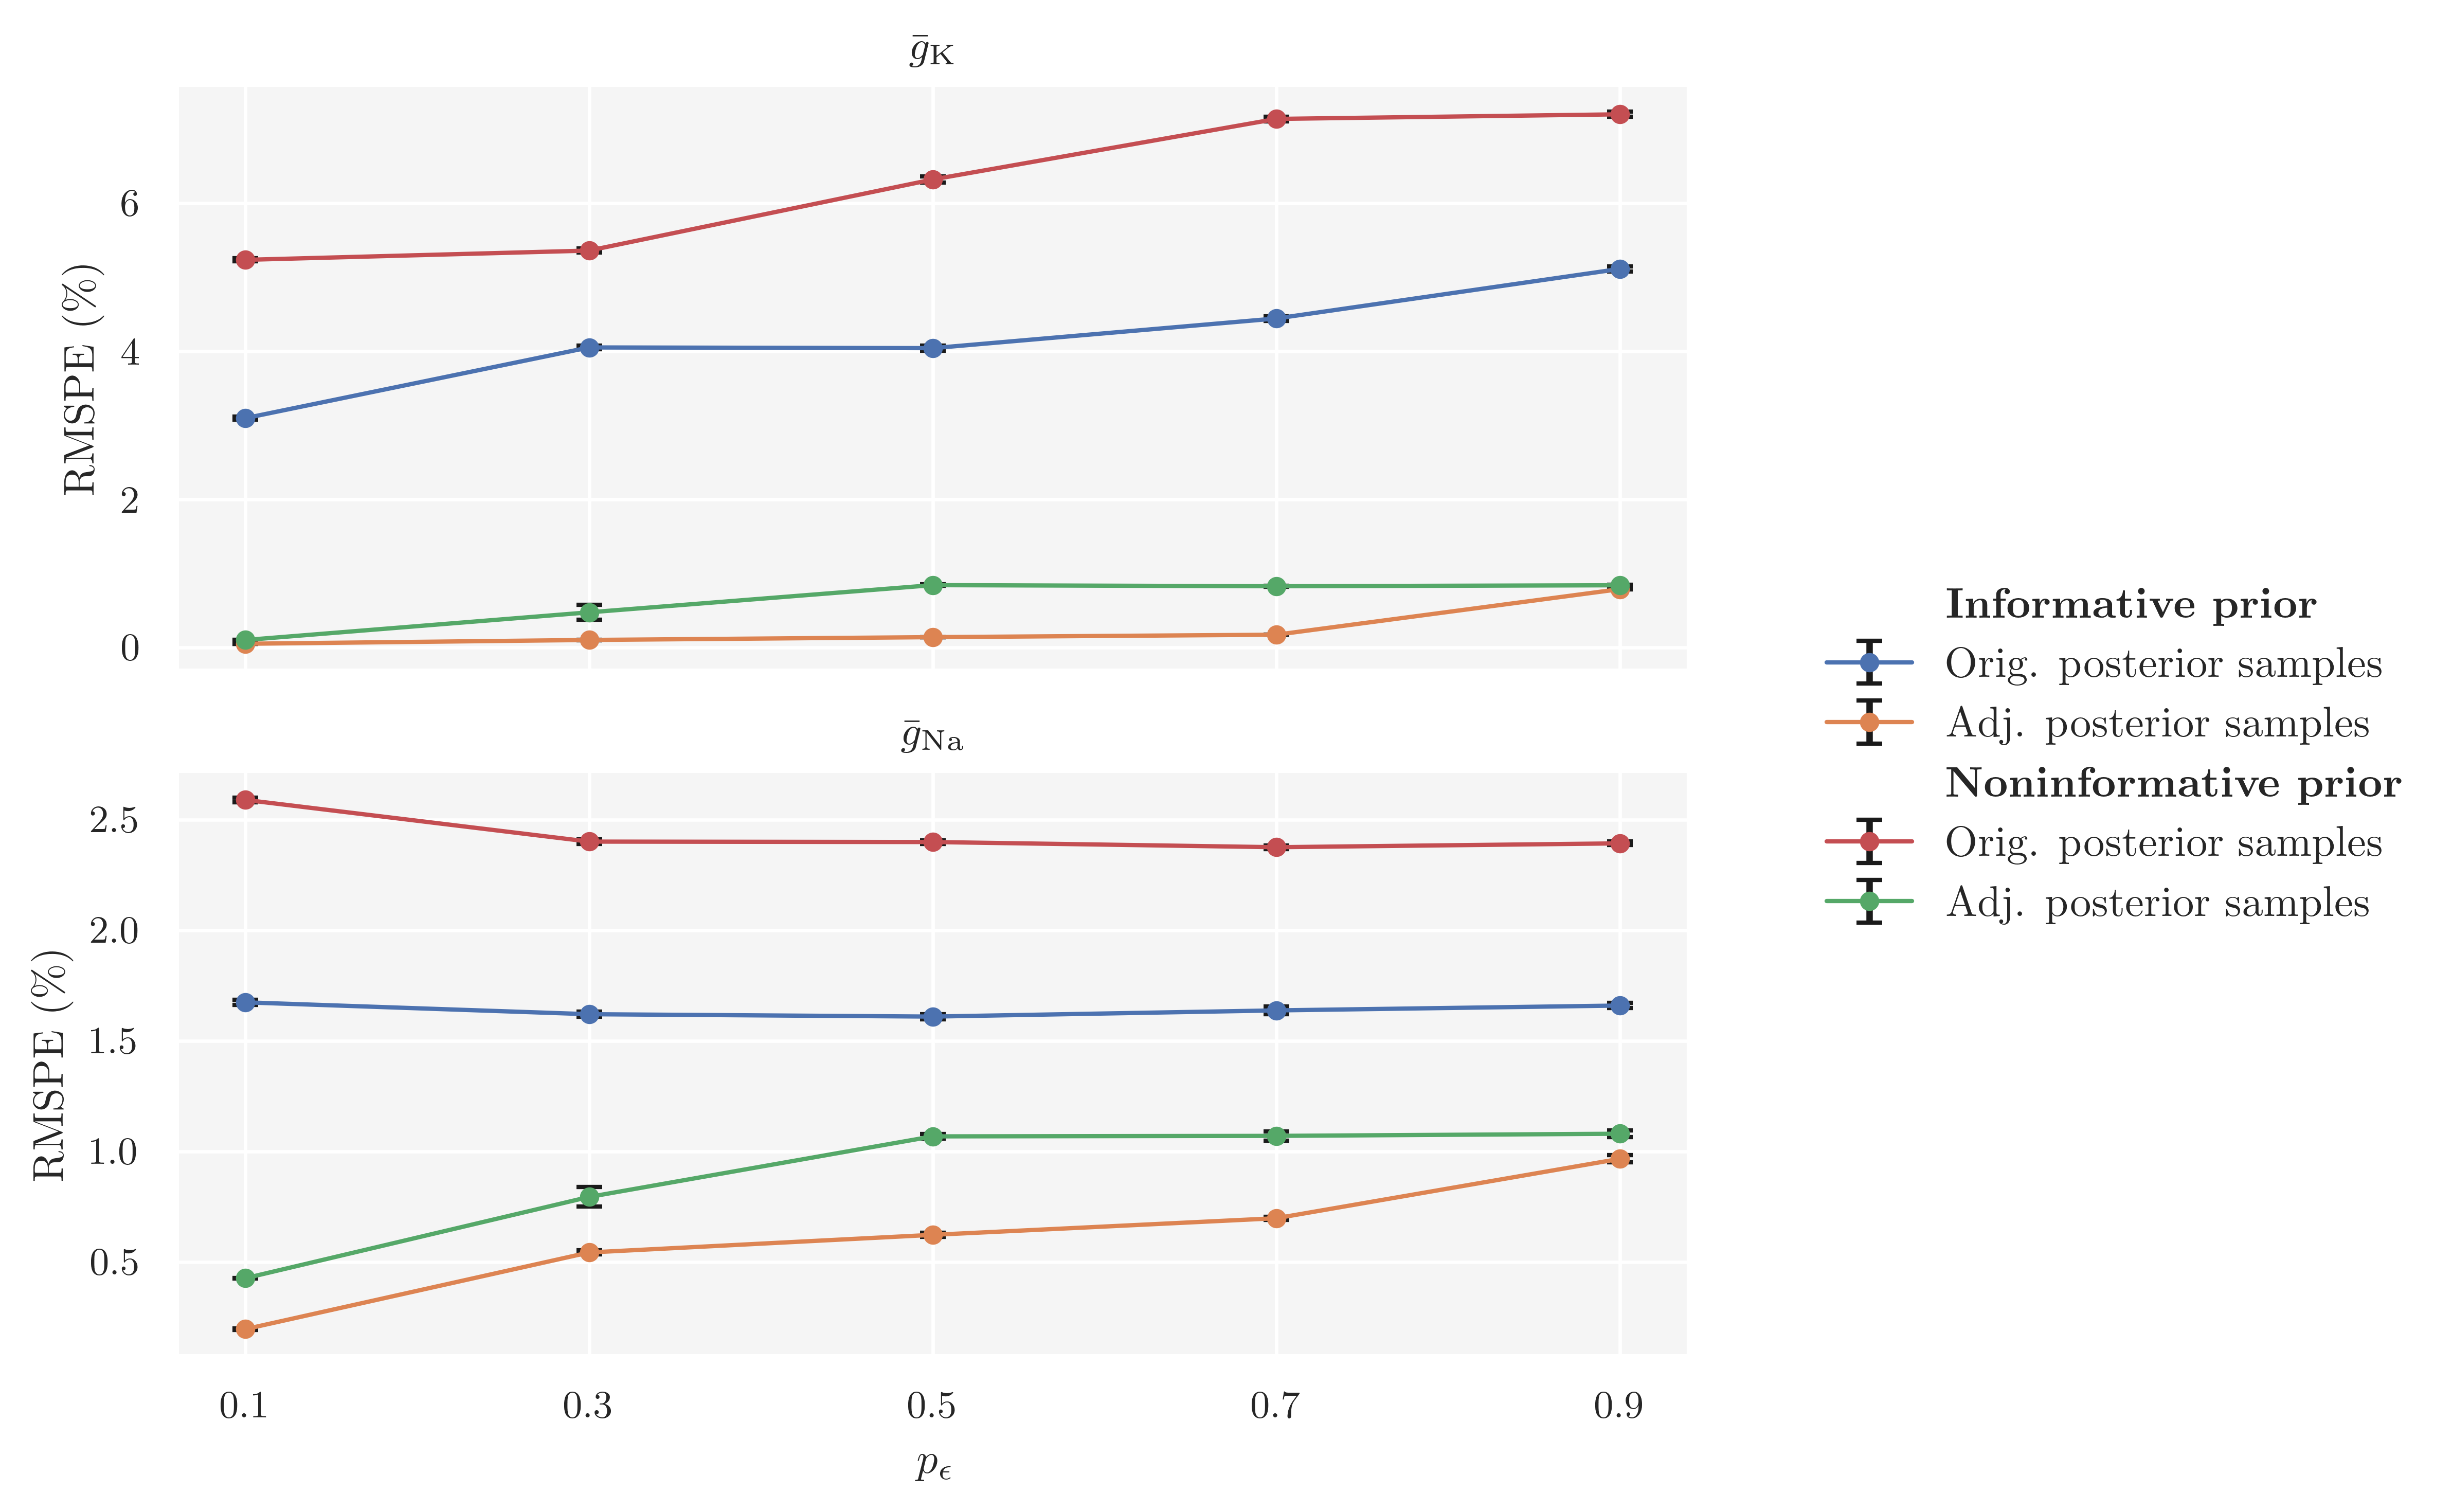

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(fs[0], 5), tight_layout=True, dpi=300, sharex=True)

# gbarK
ax = axes[0]
# informative prior
g1 = ax.errorbar(quantile_lst, 
            gbarK_org_rmspe_mean_norm, 
            yerr=gbarK_org_rmspe_sem_norm, 
            fmt='-o', 
            color='C0',
            ecolor='k',
            markersize=3.5,
            lw=1.0, 
            elinewidth=1.5,
            capsize=3,
           ) 
                
g2 = ax.errorbar(quantile_lst, 
            gbarK_reg_rmspe_mean_norm, 
            yerr=gbarK_reg_rmspe_sem_norm, 
            fmt='-o', 
            color='C1',
            ecolor='k',
            markersize=3.5,
            lw=1.0, 
            elinewidth=1.5,
            capsize=3,
           ) 


# noninformative prior
g3 = ax.errorbar(quantile_lst, 
            gbarK_org_rmspe_mean_unif, 
            yerr=gbarK_org_rmspe_sem_unif, 
            fmt='-o', 
            color='C3',
            ecolor='k',
            markersize=3.5,
            lw=1.0, 
            elinewidth=1.5,
            capsize=3,
           ) 
                
g4 = ax.errorbar(quantile_lst, 
            gbarK_reg_rmspe_mean_unif, 
            yerr=gbarK_reg_rmspe_sem_unif, 
            fmt='-o', 
            color='C2',
            ecolor='k',
            markersize=3.5,
            lw=1.0, 
            elinewidth=1.5,
            capsize=3,
           ) 

ax.set(
       #xticks=quantile_lst,
       #xlabel=r'$p_{\epsilon}$',
       ylabel="RMSPE (\%)",
       title=r'$\bar{g}_\mathrm{K}$'
       )


# gbarNa 
ax1 = axes[1]
# informative prior
ax1.errorbar(quantile_lst, 
            gbarNa_org_rmspe_mean_norm, 
            yerr=gbarNa_org_rmspe_sem_norm, 
            fmt='-o', 
            color='C0',
            ecolor='k',
            markersize=3.5,
            lw=1.0, 
            elinewidth=1.5,
            capsize=3,
           ) 
                
ax1.errorbar(quantile_lst, 
            gbarNa_reg_rmspe_mean_norm, 
            yerr=gbarNa_reg_rmspe_sem_norm, 
            fmt='-o', 
            color='C1',
            ecolor='k',
            markersize=3.5,
            lw=1.0, 
            elinewidth=1.5,
            capsize=3,
           ) 


# noninformative prior
ax1.errorbar(quantile_lst, 
            gbarNa_org_rmspe_mean_unif, 
            yerr=gbarNa_org_rmspe_sem_unif, 
            fmt='-o', 
            color='C3',
            ecolor='k',
            markersize=3.5,
            lw=1.0, 
            elinewidth=1.5,
            capsize=3,
           ) 
                
ax1.errorbar(quantile_lst, 
            gbarNa_reg_rmspe_mean_unif, 
            yerr=gbarNa_reg_rmspe_sem_unif, 
            fmt='-o', 
            color='C2',
            ecolor='k',
            markersize=3.5,
            lw=1.0, 
            elinewidth=1.5,
            capsize=3,
           ) 

ax1.set(xticks=quantile_lst,
       xlabel=r'$p_{\epsilon}$',
       ylabel="RMSPE (\%)",
       title=r'$\bar{g}_\mathrm{Na}$'
       )

# legend
title_proxy = matplotlib.patches.Rectangle((0, 0), 0, 0, visible=False)#, color='')
title1 = r"\textbf{Informative prior}"
title2 = r"\textbf{Noninformative prior}"
label1 = "Orig. posterior samples"
label2 = "Adj. posterior samples"

fig.legend([title_proxy, g1, g2, title_proxy, g3, g4],
          [title1, label1, label2, title2, label1, label2],
          loc='center left',
          bbox_to_anchor=(1.04, 0.5),
          fancybox=True,
          borderaxespad=0.1,
          frameon=False,
          ncol=1
         )

fig.savefig(fig_path('RMSPE_vs_quantile.pdf'), 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight'
           )

## Computational time

Compromise between level of accuracy and computation efficiency 

"Runtime (s)" on y-axis instead?

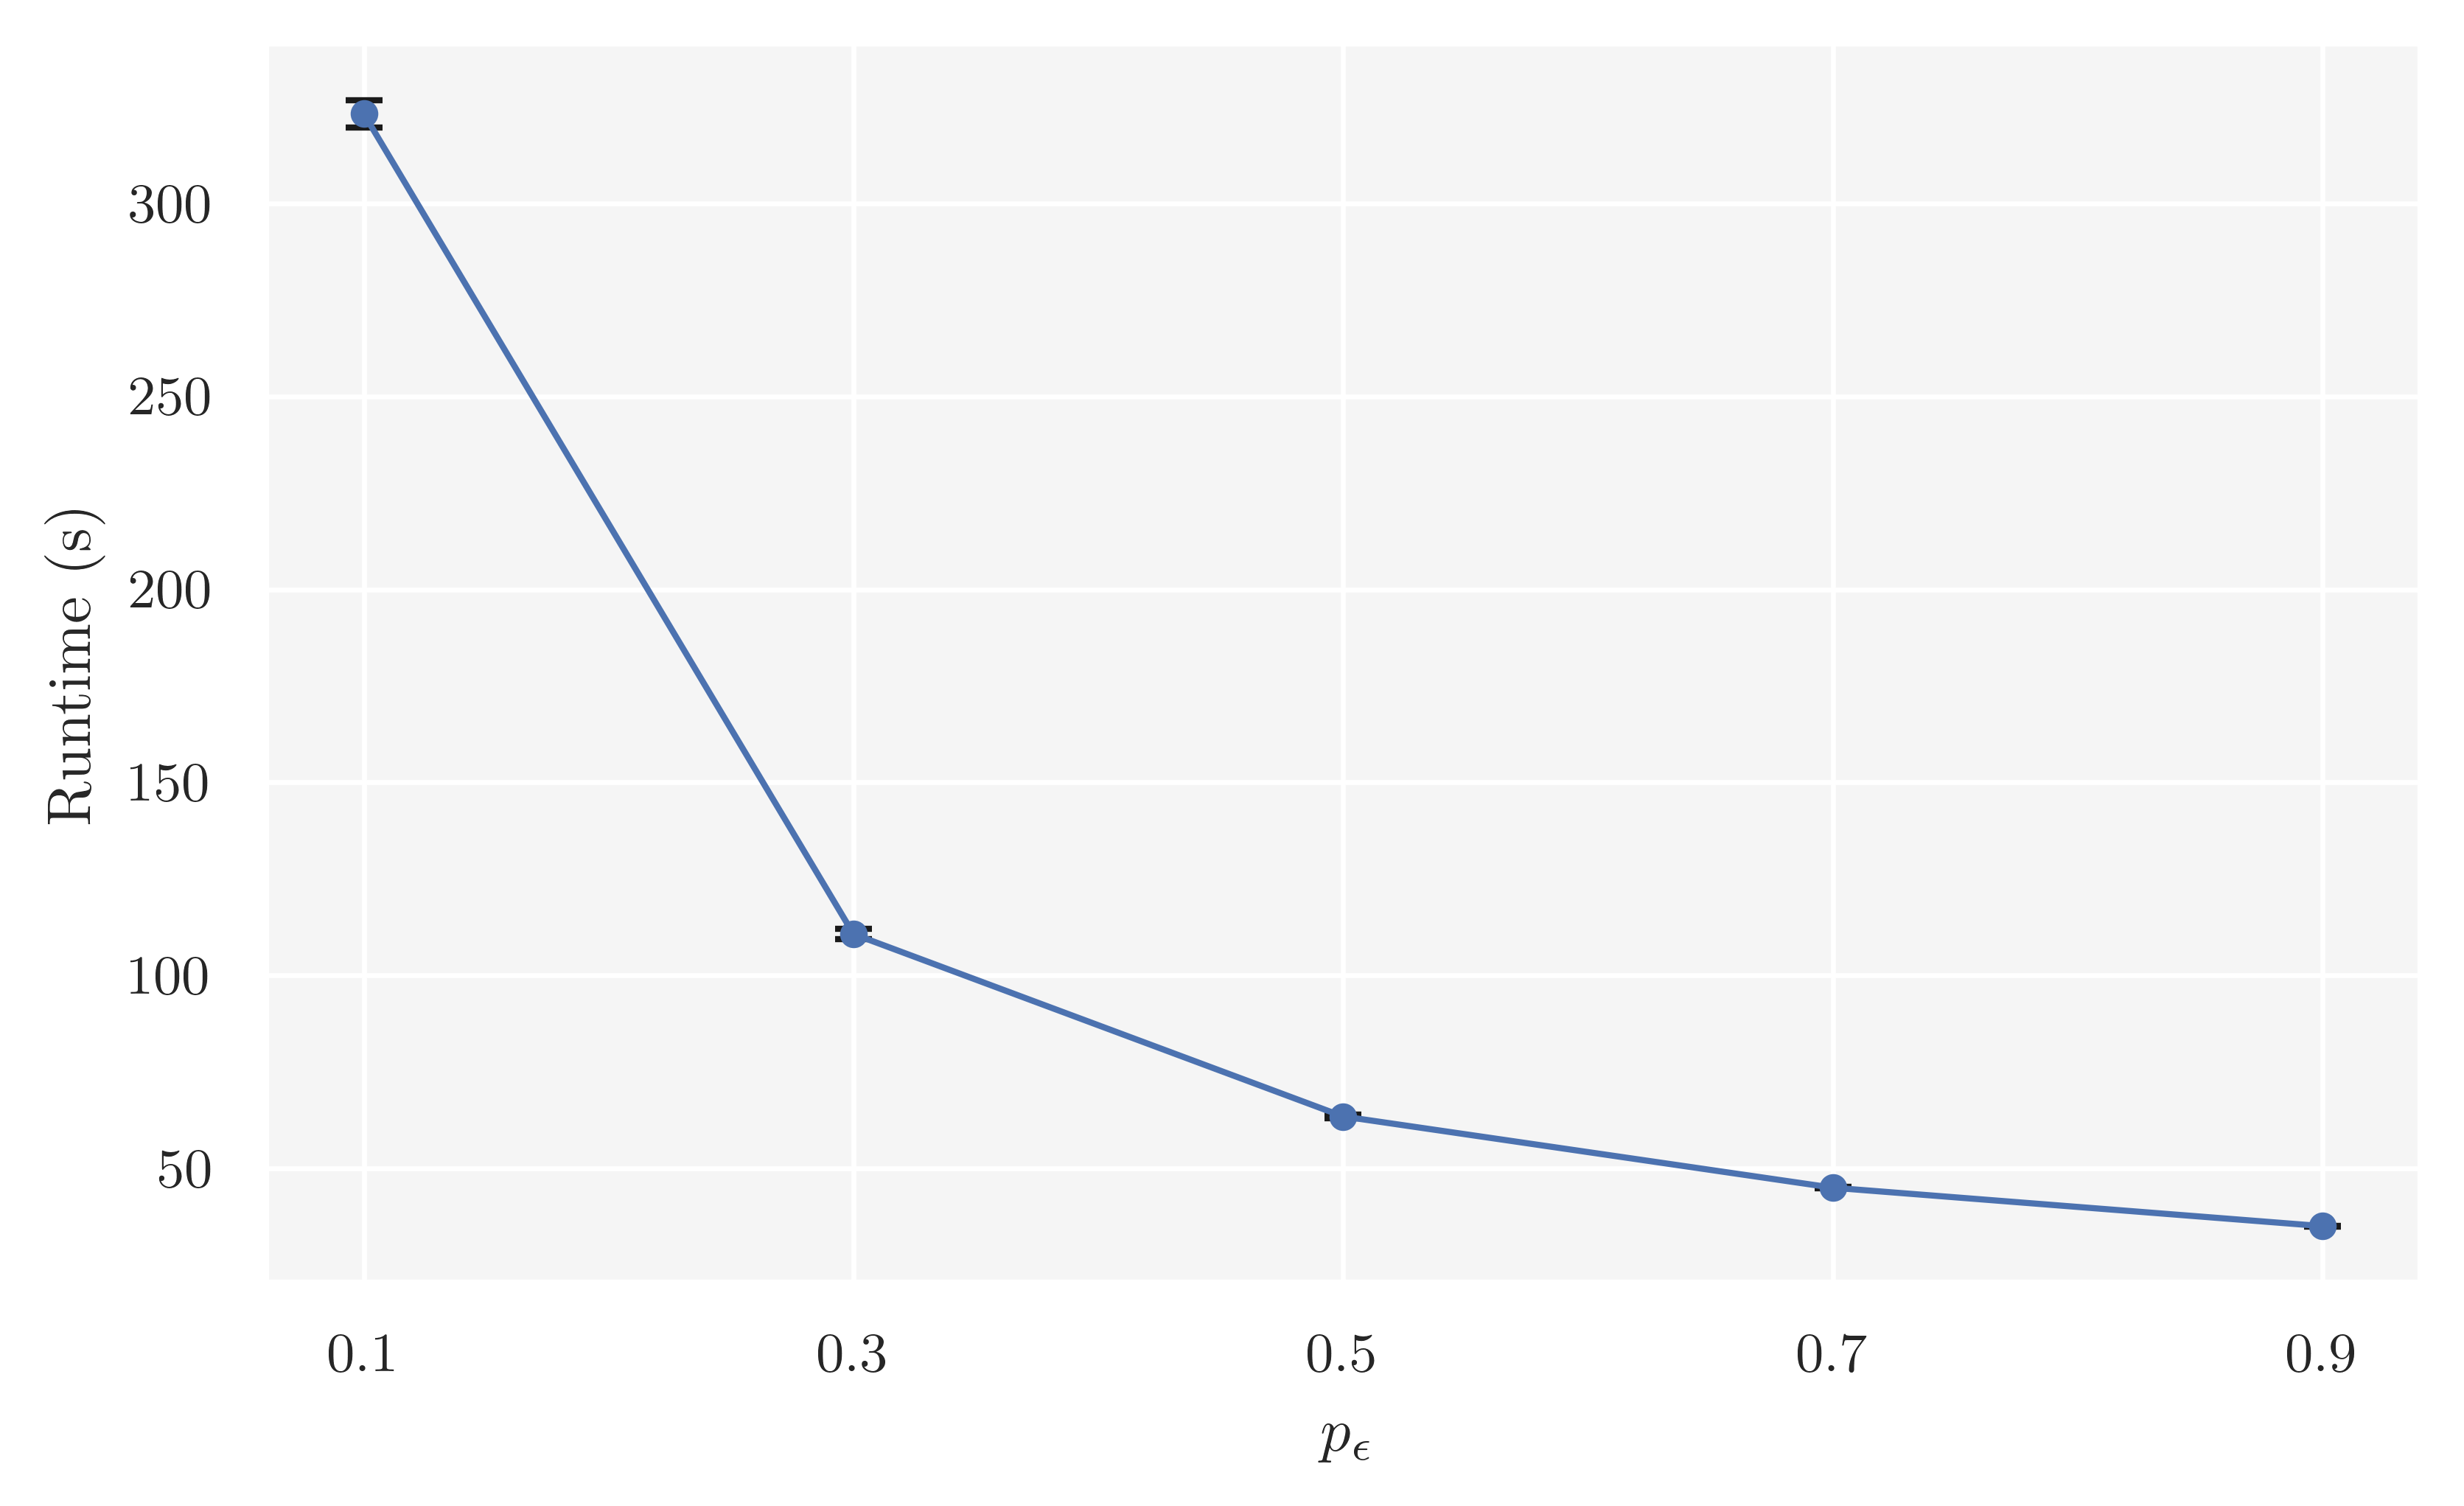

In [7]:
fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=300)

df_time = pd.read_csv('data/run_time_quantile.csv')
x_time = df_time['quantile'].unique()
mean_time = df_time.groupby('quantile').mean().to_numpy().ravel()
sem_time = df_time.groupby('quantile').sem().to_numpy().ravel() 

ax.errorbar(x_time, 
            mean_time, 
            yerr=sem_time, 
            fmt='-o', 
            color='C0',
            ecolor='k',
            markersize=3.5,
            lw=1.0, 
            elinewidth=1.5,
            capsize=3,
           )

ax.set(xticks=x_time,
       xlabel=r'$p_{\epsilon}$',
       #ylabel='Computational (wall clock) time (s)'
       ylabel="Runtime (s)"
      )

fig.savefig(fig_path('comp_time_quantile.pdf'), 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight'
           )

## RMSPE vs number of summary statistics

In [8]:
gbarK0 = 36.    # ground truth
gbarNa0 = 120.  # ground truth

n_samples = 1000
gbarK_true = np.ones(n_samples) * gbarK0
gbarNa_true = np.ones(n_samples) * gbarNa0

# iterators
s_stats_all = ["average_AP_overshoot",
               "spike_rate",
               "average_AP_width",
               "average_AHP_depth",
               "latency_to_first_spike",
               "accommodation_index"]

N = len(s_stats_all)

# eqaul weights
gbarK_rmspe_norm_ew = np.zeros(N)
gbarNa_rmspe_norm_ew = np.zeros(N)

gbarK_rmspe_unif_ew = np.zeros(N)
gbarNa_rmspe_unif_ew = np.zeros(N)

# importance weights
gbarK_rmspe_norm_iw = np.zeros(N)
gbarNa_rmspe_norm_iw = np.zeros(N)

gbarK_rmspe_unif_iw = np.zeros(N)
gbarNa_rmspe_unif_iw = np.zeros(N)

for i in range(N):
    
    # normal prior, equal weights
    filename = f'hh_rej_normal_nsumstats_{i+1}_eweights.jnl'
    journal = pylfi.Journal.load(path + filename)
    df = journal.df
    
    gbarK_rmspe_norm_ew[i] = rmspe(gbarK_true, df["gbarK"].to_numpy())
    gbarNa_rmspe_norm_ew[i] = rmspe(gbarNa_true, df["gbarNa"].to_numpy())  
    
    # uniform prior, equal weights 
    filename = f'hh_rej_uniform_nsumstats_{i+1}_eweights.jnl'
    journal = pylfi.Journal.load(path + filename)
    df = journal.df
    
    gbarK_rmspe_unif_ew[i] = rmspe(gbarK_true, df["gbarK"].to_numpy())
    gbarNa_rmspe_unif_ew[i] = rmspe(gbarNa_true, df["gbarNa"].to_numpy())
    
    # normal prior, importance weights
    filename = f'hh_rej_normal_nsumstats_{i+1}_iweights.jnl'
    journal = pylfi.Journal.load(path + filename)
    df = journal.df
    
    gbarK_rmspe_norm_iw[i] = rmspe(gbarK_true, df["gbarK"].to_numpy())
    gbarNa_rmspe_norm_iw[i] = rmspe(gbarNa_true, df["gbarNa"].to_numpy())
    
    # uniform prior, importance weights 
    filename = f'hh_rej_uniform_nsumstats_{i+1}_iweights.jnl'
    journal = pylfi.Journal.load(path + filename)
    df = journal.df
    
    gbarK_rmspe_unif_iw[i] = rmspe(gbarK_true, df["gbarK"].to_numpy())
    gbarNa_rmspe_unif_iw[i] = rmspe(gbarNa_true, df["gbarNa"].to_numpy())
    

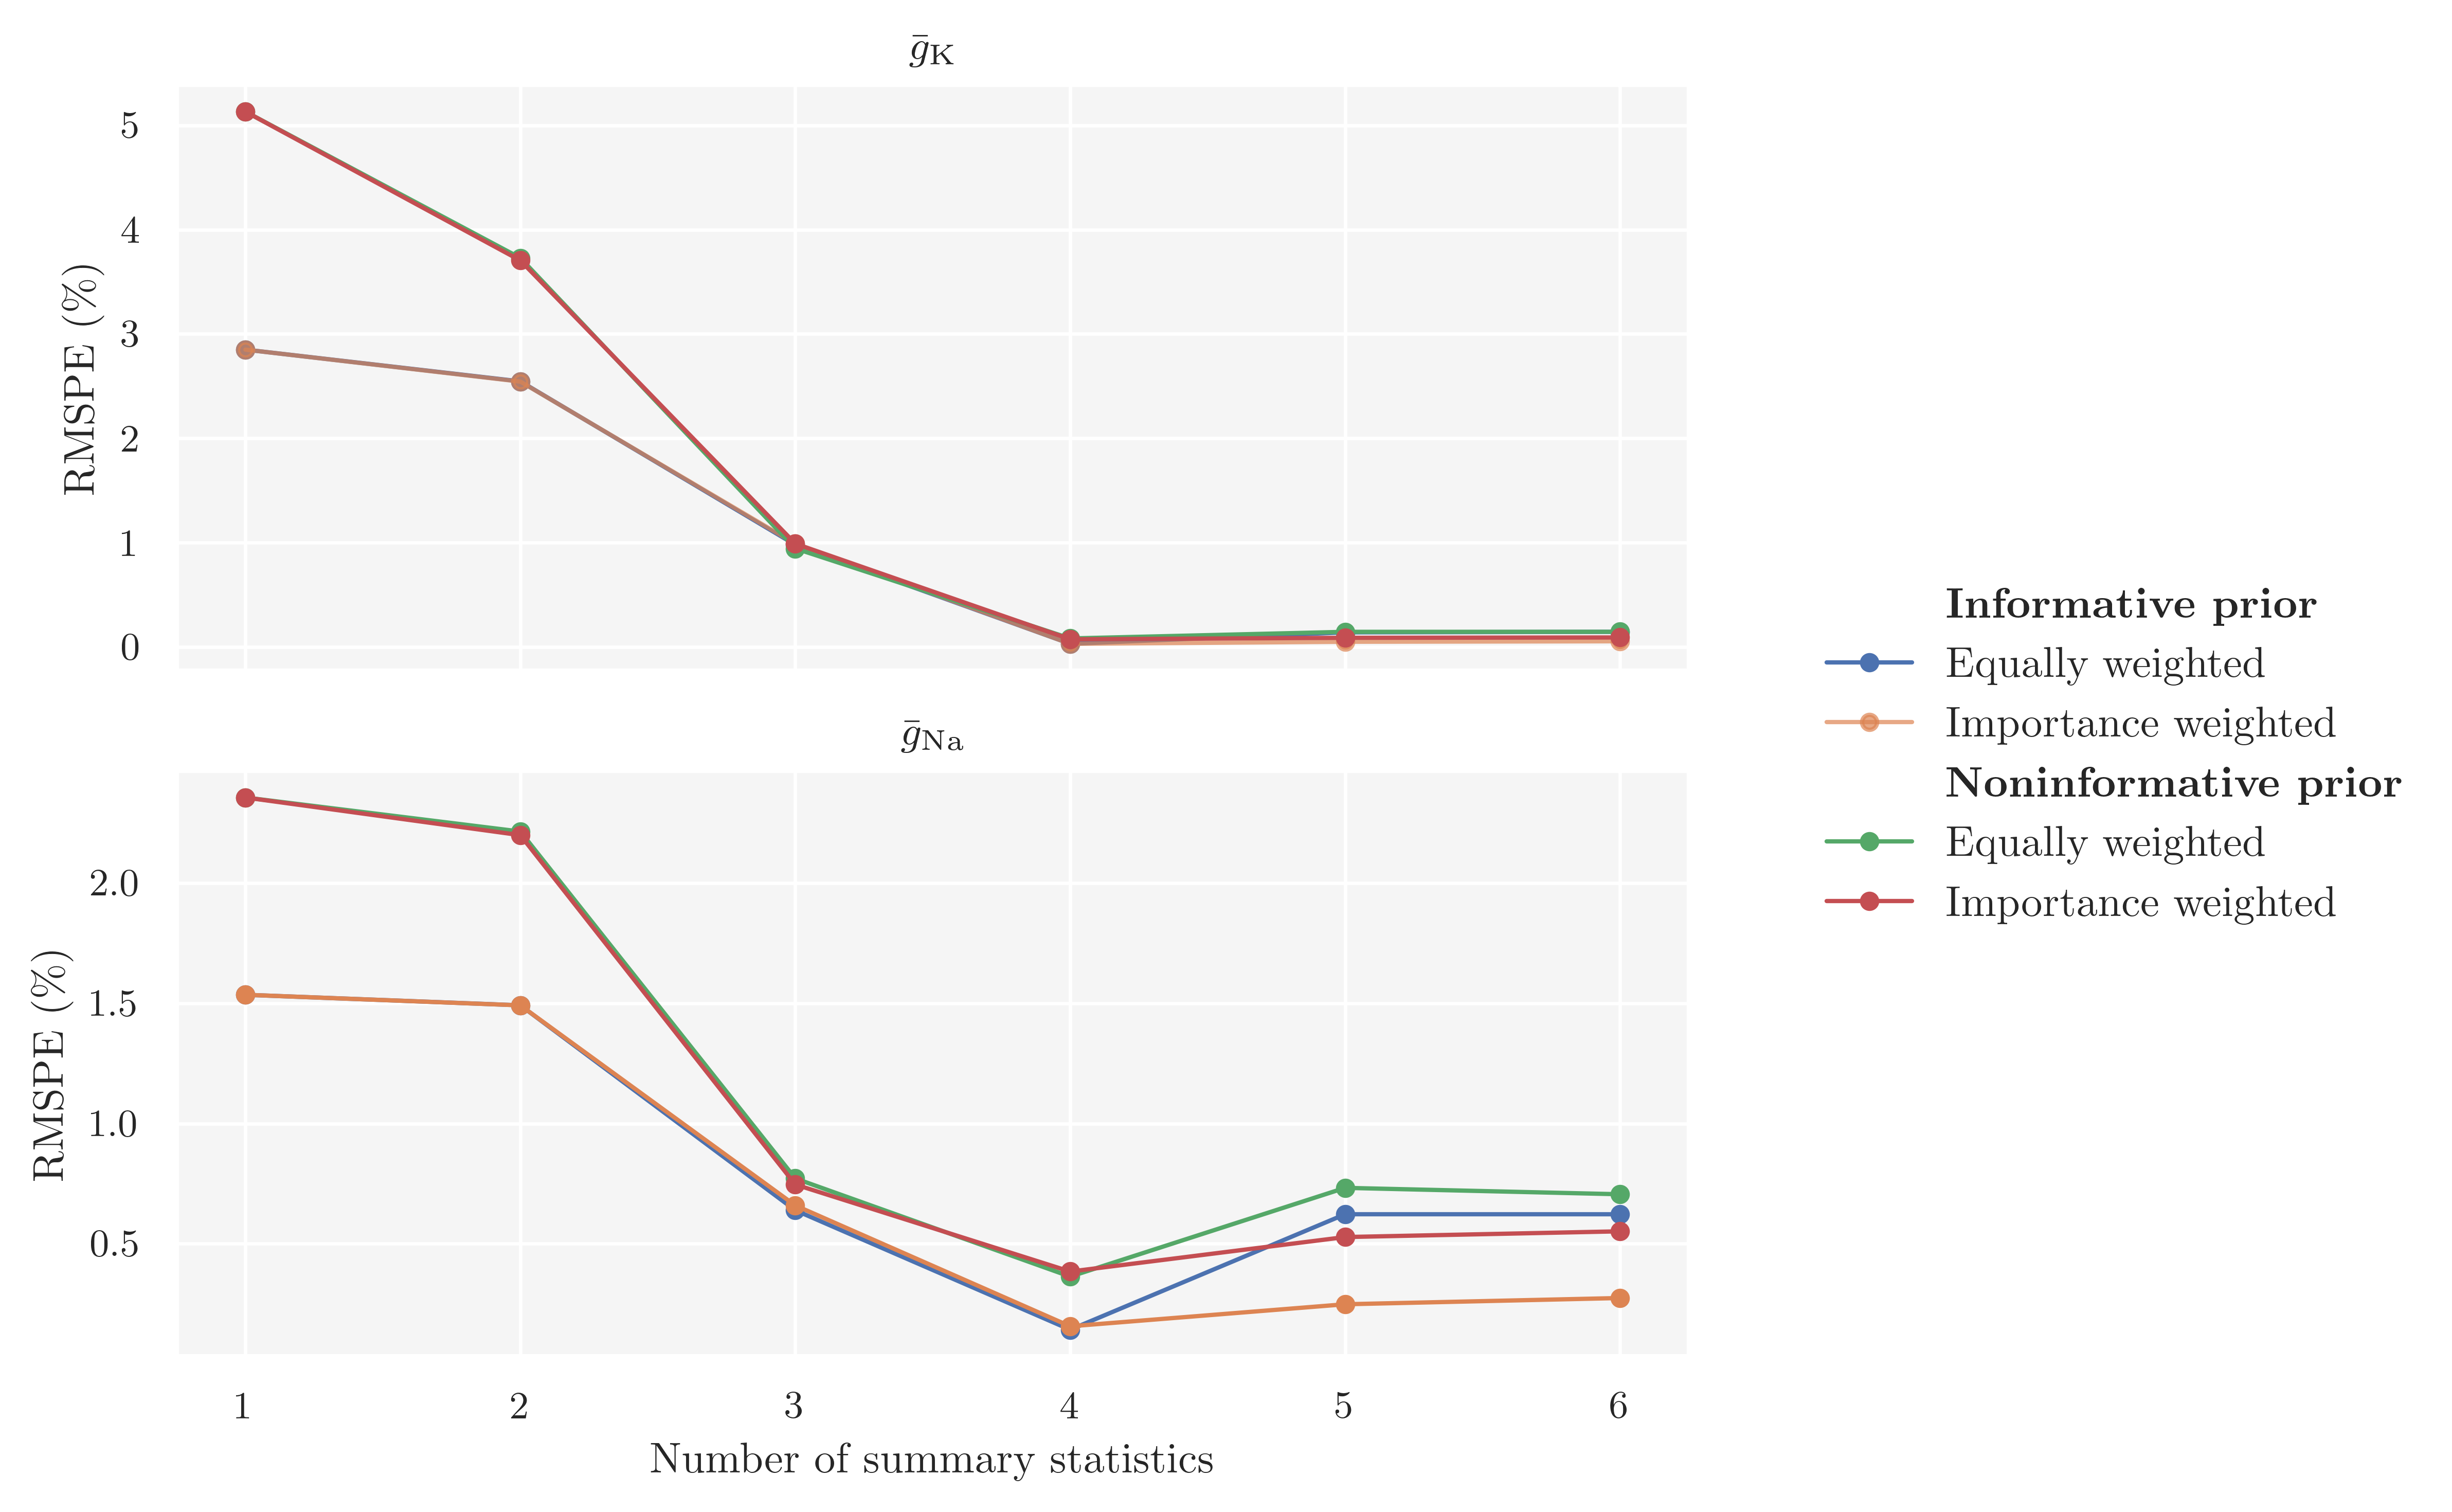

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(fs[0], 5), tight_layout=True, dpi=300, sharex=True)

n_sumstats = np.arange(1, N+1)

# gbarK
ax = axes[0]

# informative prior
g1, = ax.plot(n_sumstats, 
              gbarK_rmspe_norm_ew,
              '-o', 
              color='C0',
              markersize=3.5,
              lw=1.0
             )

g2, = ax.plot(n_sumstats, 
              gbarK_rmspe_norm_iw,
              '-o', 
              color='C1',
              markersize=3.5,
              alpha=0.7,
              lw=1.0
             ) 

# noninformative prior
g3, = ax.plot(n_sumstats, 
             gbarK_rmspe_unif_ew,
             '-o', 
             color='C2',
             markersize=3.5,
             lw=1.0
            )

g4, = ax.plot(n_sumstats, 
             gbarK_rmspe_unif_iw,
             '-o', 
             color='C3',
             markersize=3.5,
             lw=1.0
            ) 

ax.set(ylabel="RMSPE (\%)",
       title=r'$\bar{g}_\mathrm{K}$'
       )


# gbarNa
ax1 = axes[1]

# informative prior
ax1.plot(n_sumstats,
         gbarNa_rmspe_norm_ew,
         '-o', 
         color='C0',
         markersize=3.5,
         lw=1.0
        )

ax1.plot(n_sumstats, 
         gbarNa_rmspe_norm_iw,
         '-o', 
         color='C1',
         markersize=3.5,
         lw=1.0
        ) 

# noninformative prior
ax1.plot(n_sumstats, 
         gbarNa_rmspe_unif_ew,
         '-o', 
         color='C2',
         markersize=3.5,
         lw=1.0
        )

ax1.plot(n_sumstats,
         gbarNa_rmspe_unif_iw,
         '-o', 
         color='C3',
         markersize=3.5,
         lw=1.0
        ) 

ax1.set(
    #xticks=nsamples_lst,
       xlabel='Number of summary statistics',
       ylabel="RMSPE (\%)",
       title=r'$\bar{g}_\mathrm{Na}$'
       )

# legend
title_proxy = matplotlib.patches.Rectangle((0, 0), 0, 0, visible=False)#, color='')
title1 = r"\textbf{Informative prior}"
title2 = r"\textbf{Noninformative prior}"
label1 = "Equally weighted"
label2 = "Importance weighted"

fig.legend([title_proxy, g1, g2, title_proxy, g3, g4],
          [title1, label1, label2, title2, label1, label2],
          loc='center left',
          bbox_to_anchor=(1.04, 0.5),
          fancybox=True,
          borderaxespad=0.1,
          frameon=False,
          ncol=1
         )


fig.savefig(fig_path('RMSPE_vs_n_sumstats.pdf'), 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight'
           )

## Posteriors

### Original samples, informative prior

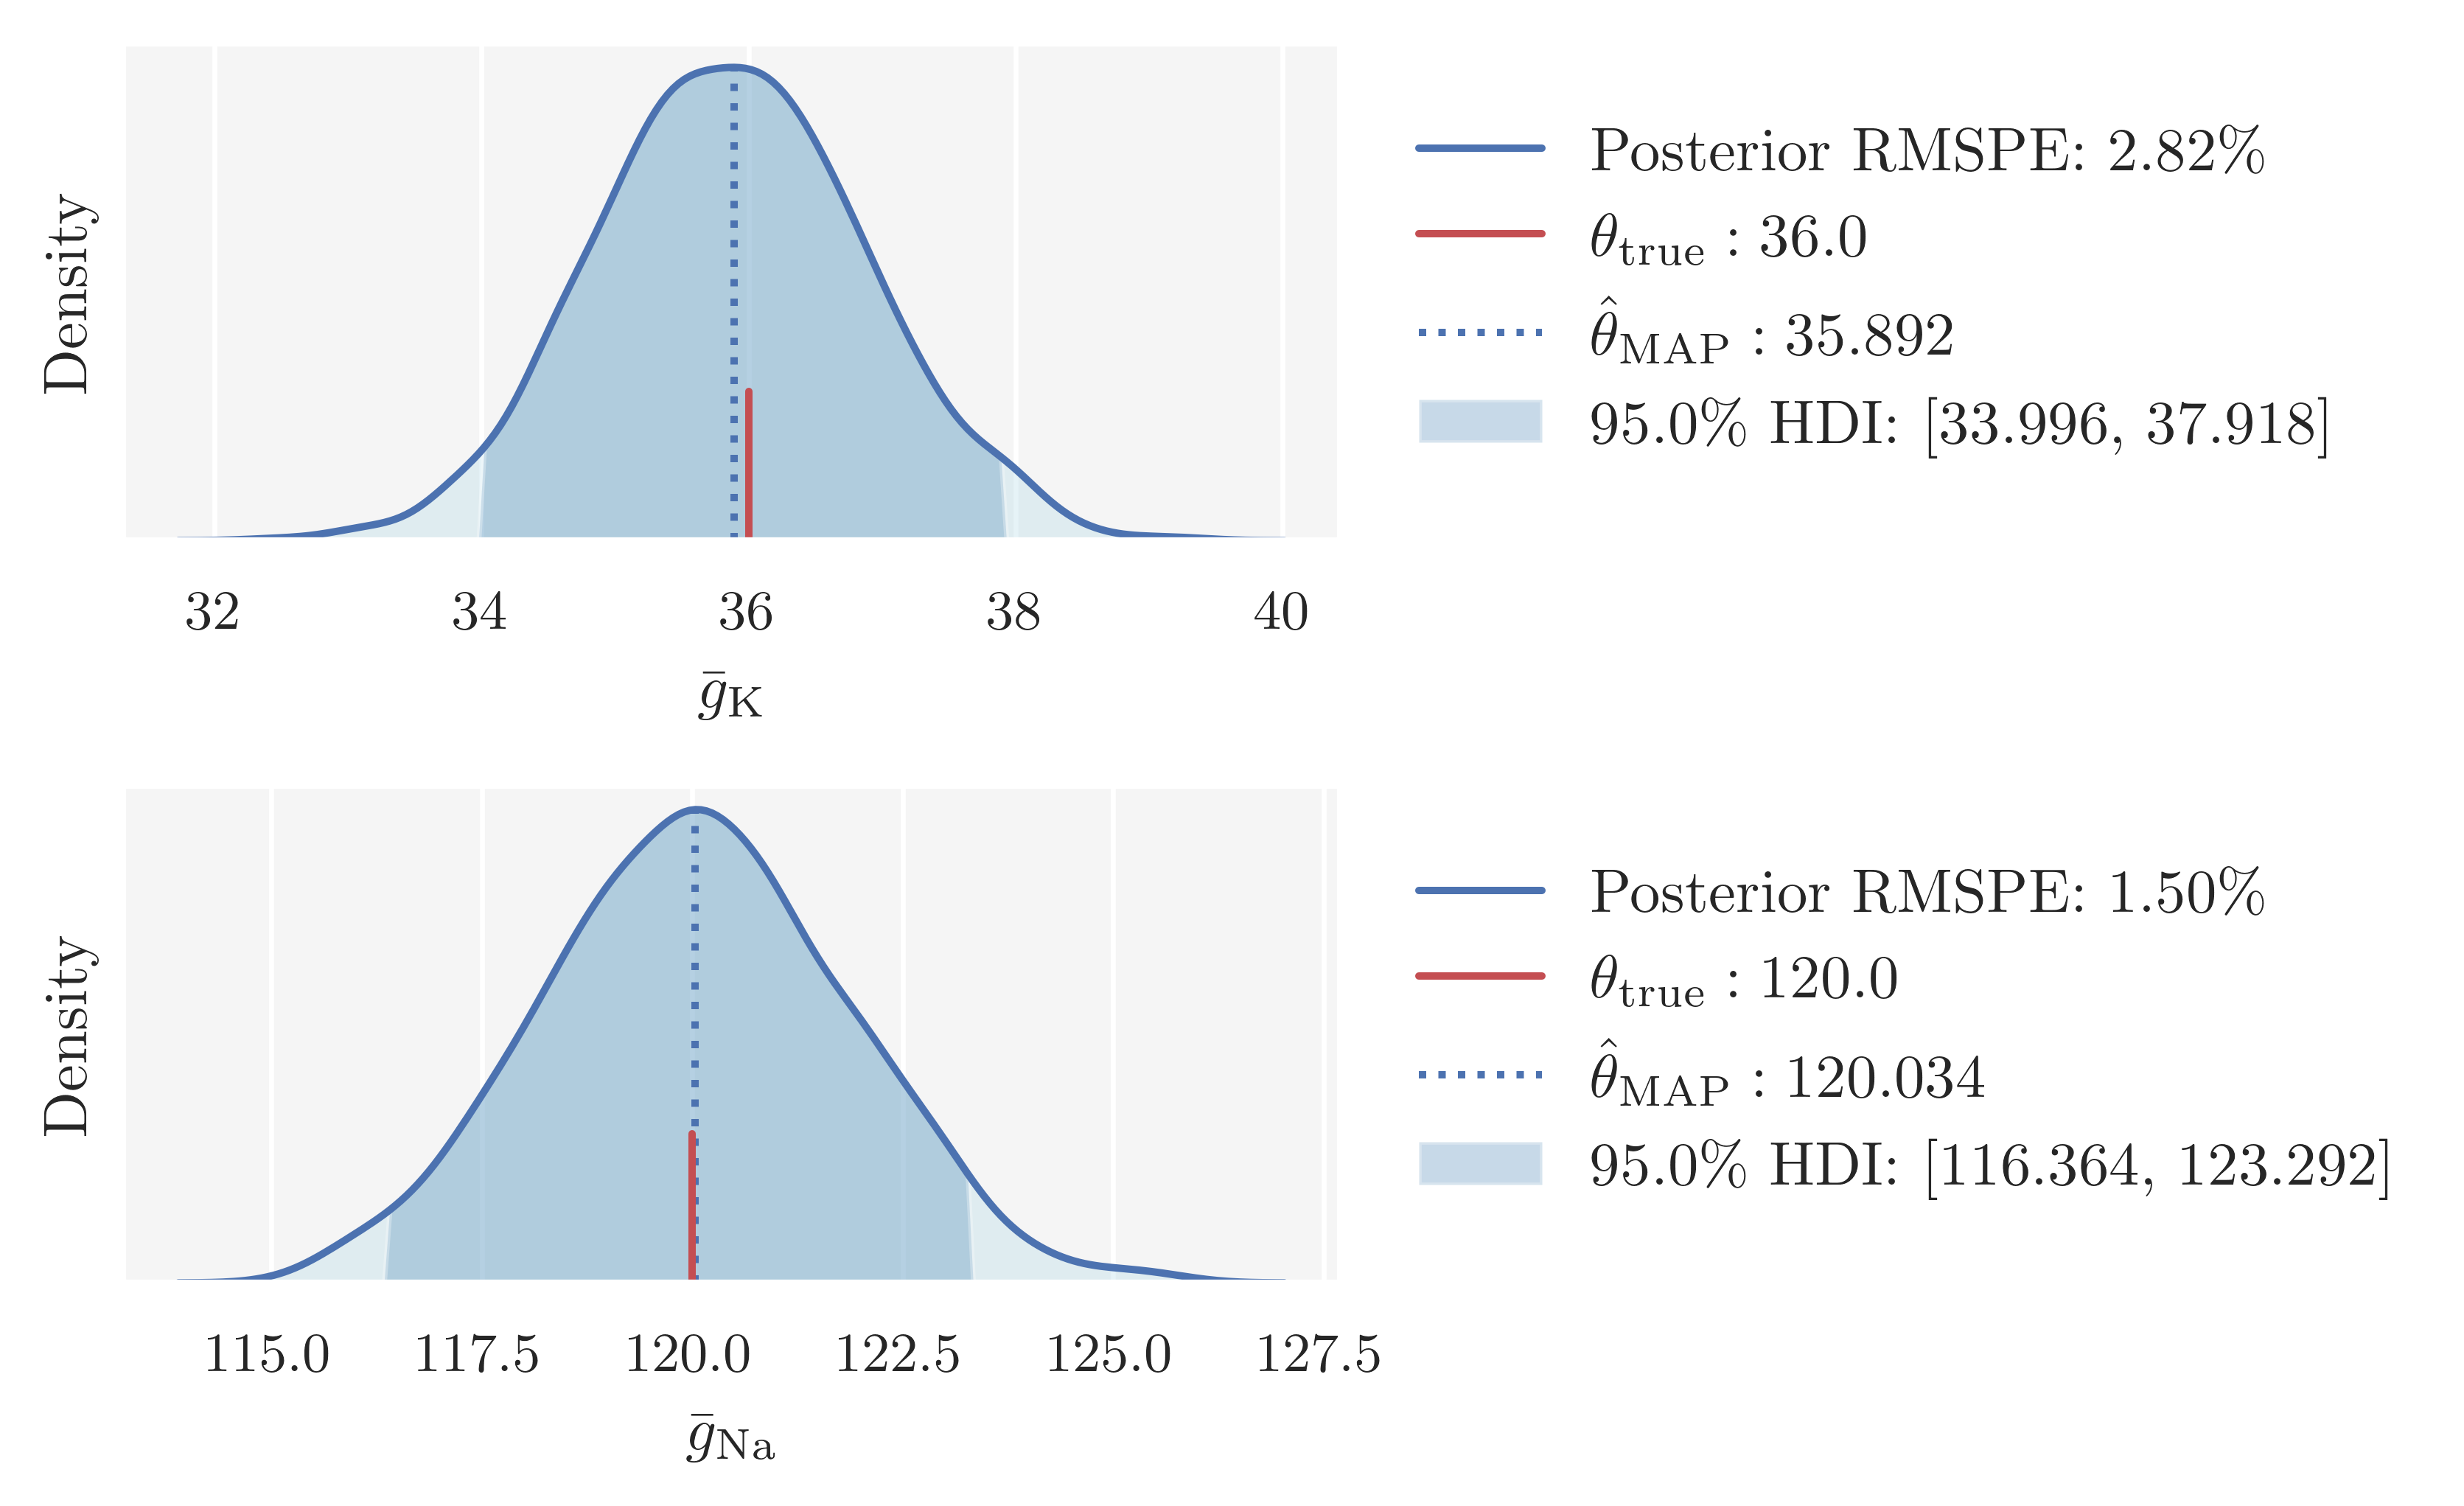

In [10]:
filename = f'hh_rej_normal_best_posterior_org.jnl'
journal_org = pylfi.Journal.load(path + filename)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=fs, tight_layout=True, dpi=300)
journal_org.plot_posterior('gbarK', point_estimate='map', theta_true=36., ax=axes[0])
journal_org.plot_posterior('gbarNa', point_estimate='map', theta_true=120., ax=axes[1])

fig.savefig(fig_path('hh_posterior_org_normal.pdf'), 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight'
           )

#### Correlation

The off-diagonal values tell us that the, perhaps unsurprisingly, parameter pairs are correlated. In particular, they have a positive correlation, which means that an increase of one gives an increase of the other. 

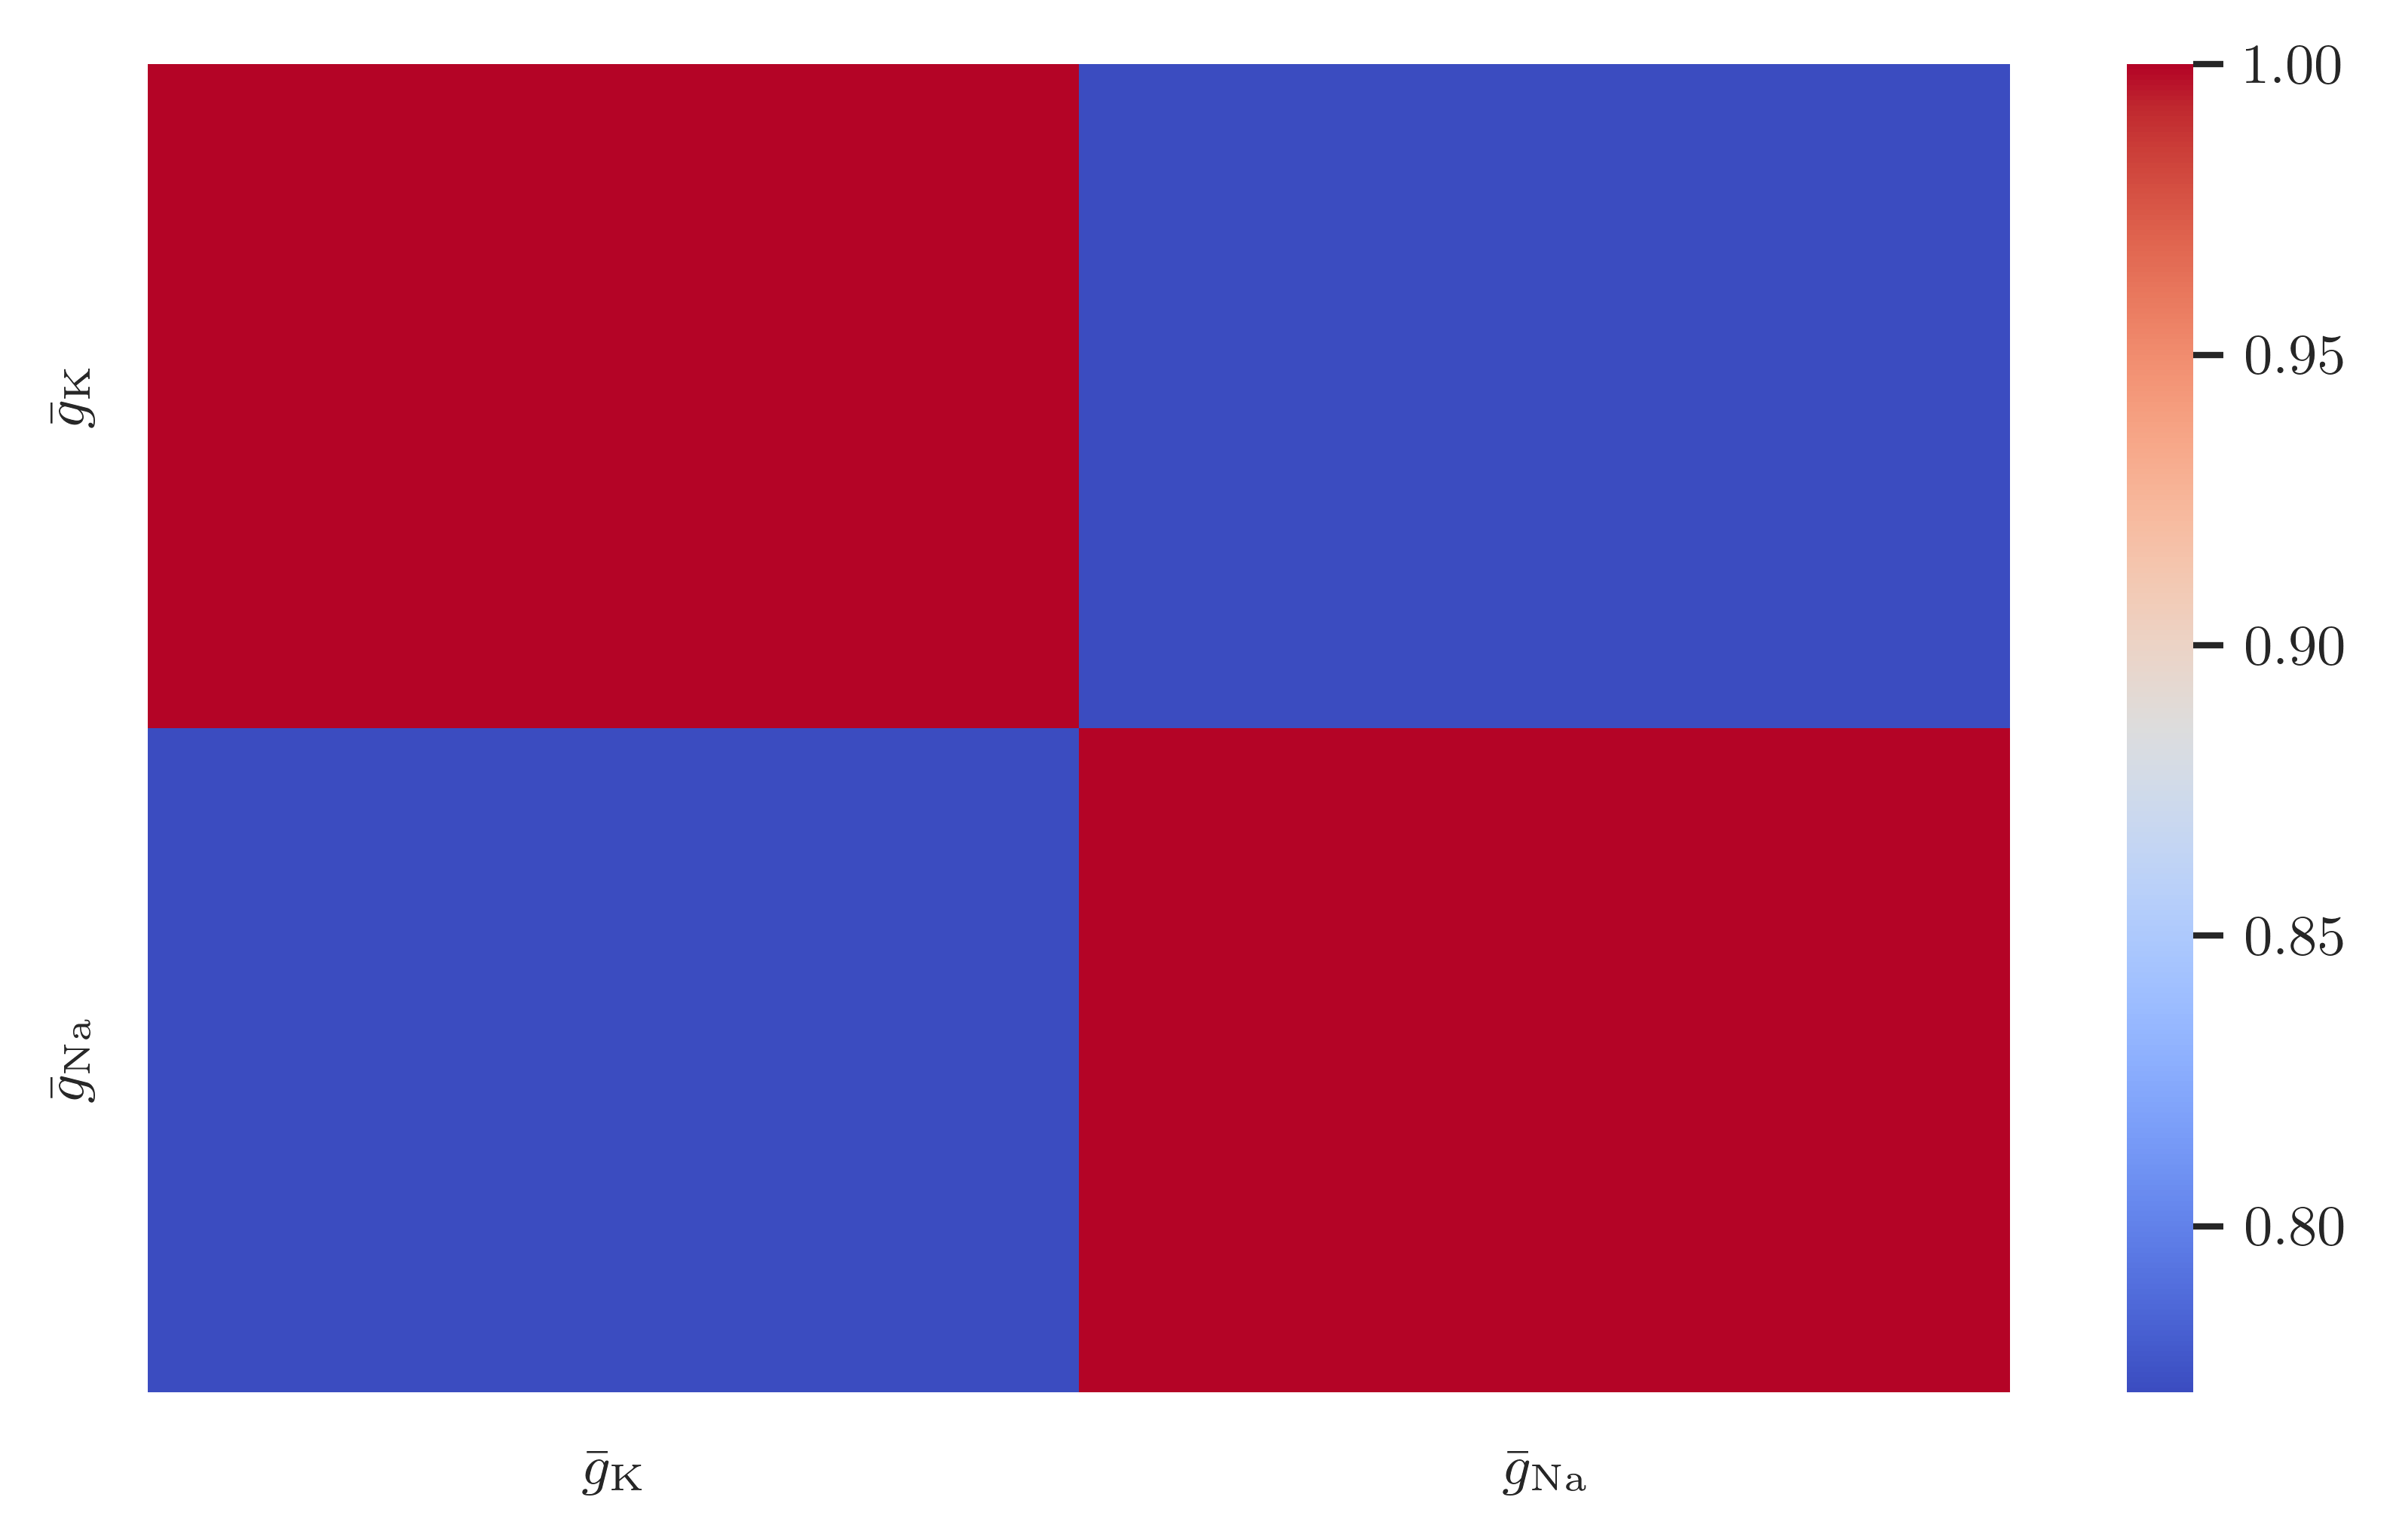

In [11]:
fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=300)
journal_org.heatmap("corr", ax=ax)

fig.savefig(fig_path('hh_corr_org_normal.pdf'), 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight'
           )

The correlation plot tells us that we need to sample from the joint posterior distribution when we want to make predictions:

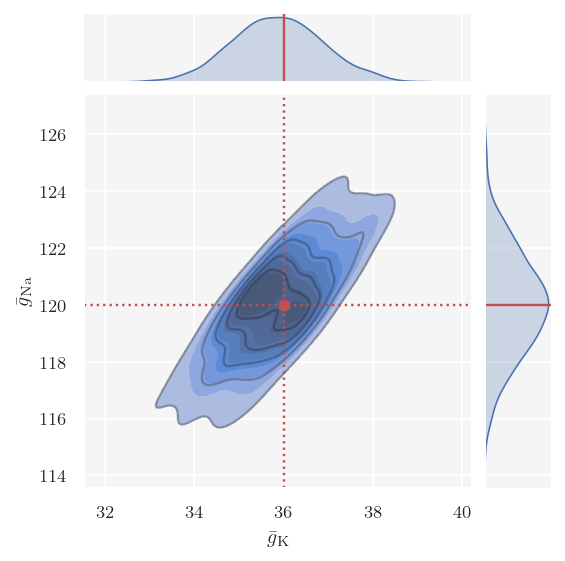

In [12]:
g = journal_org.plot_joint('gbarK', 'gbarNa', 36., 120., height=4)

g.savefig(fig_path('hh_joint_posterior_org_normal.pdf'), 
          format='pdf', 
          dpi=300, 
          bbox_inches='tight'
         )

### Adjusted posterior, informative prior

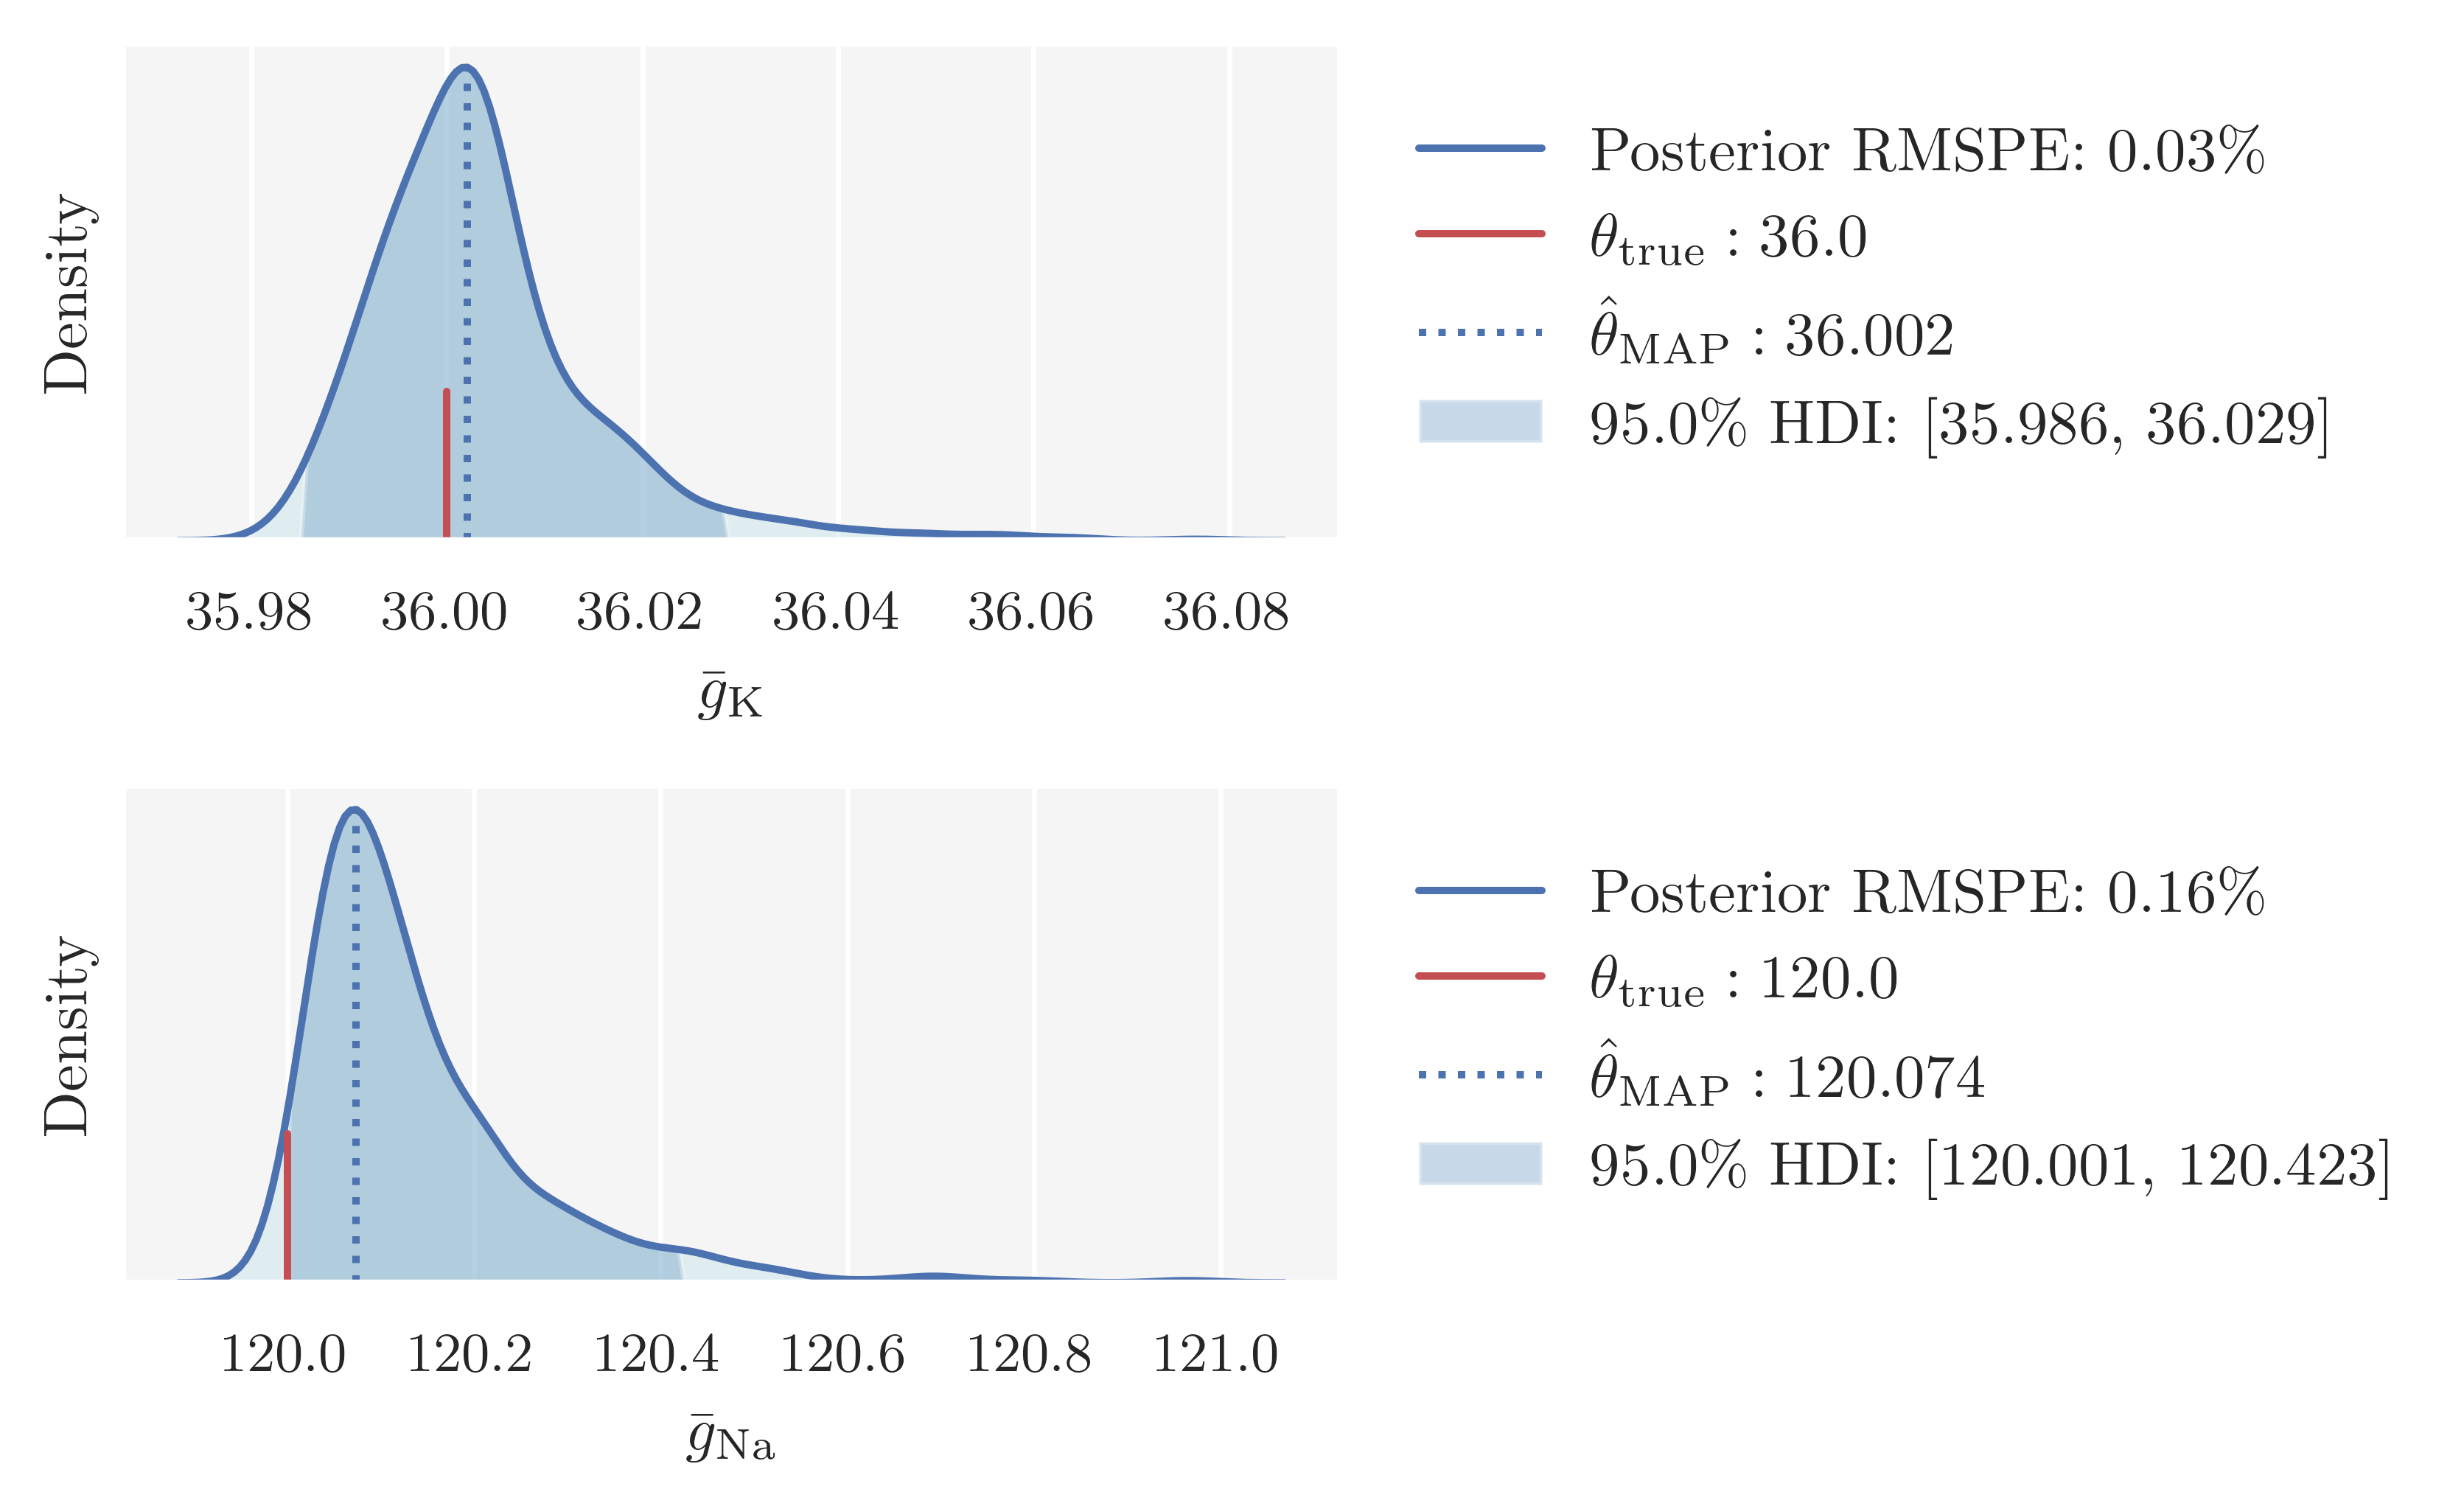

In [13]:
filename = f'hh_rej_normal_best_posterior_reg.jnl'
journal_reg = pylfi.Journal.load(path + filename)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=fs, tight_layout=True, dpi=300)
journal_reg.plot_posterior('gbarK', point_estimate='map', theta_true=36., ax=axes[0])
journal_reg.plot_posterior('gbarNa', point_estimate='map', theta_true=120., ax=axes[1])

fig.savefig(fig_path('hh_posterior_reg_normal.pdf'), 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight'
           )

### Posterior Predictive

In [14]:
def hh_posterior_predictive(obs_data, simulator, thetas_pred, ax=None):
    if ax is None:
        ax = plt.gca()
        
    post_preds = np.array([hh(*theta) for theta in thetas_pred])
    mean_pred = np.mean(post_preds, axis=0)
    
    p1, = ax.plot(obs_data[1], obs_data[0], color='k', lw=1.0, zorder=1)
    
    for pred in post_preds:
        p2, = ax.plot(pred[1], pred[0], color='C0', alpha=0.2, zorder=0)
    
    p3, = ax.plot(mean_pred[1], mean_pred[0], color='C1', ls='--', dashes=(5, 5), lw=1.0, zorder=2)
    
    ax.set(xlabel="Time (ms)",
           ylabel="Membrane Potential (mV)"
          )
    
    ax.legend(
        [p1, p2, p3],
        ['Observation', 'Posterior predictive', 'Posterior predictive mean'],
        loc='center left',
        bbox_to_anchor=(1.04, 0.5),
        fancybox=True,
        borderaxespad=0.1,
        ncol=1,
        frameon=False
    )

In [15]:
# Simulator model
T = 120           # Simulation time [ms]
dt = 0.025        # Time step [ms]
I_amp = 10        # Input stimuls amplitude [microA/cm^2]
t_stim_on = 10    # Stimulus onset [ms]
t_stim_off = 110  # Stimulus offset [ms]
stimulus = nm.stimulus.Constant(I_amp, t_stim_on, t_stim_off)

hh = nm.models.HodgkinHuxley(stimulus, T, dt)

# Observed data
gbarK0 = 36.
gbarNa0 = 120.

V, t = hh(gbar_K=gbarK0, gbar_Na=gbarNa0)
obs_data = (V, t)

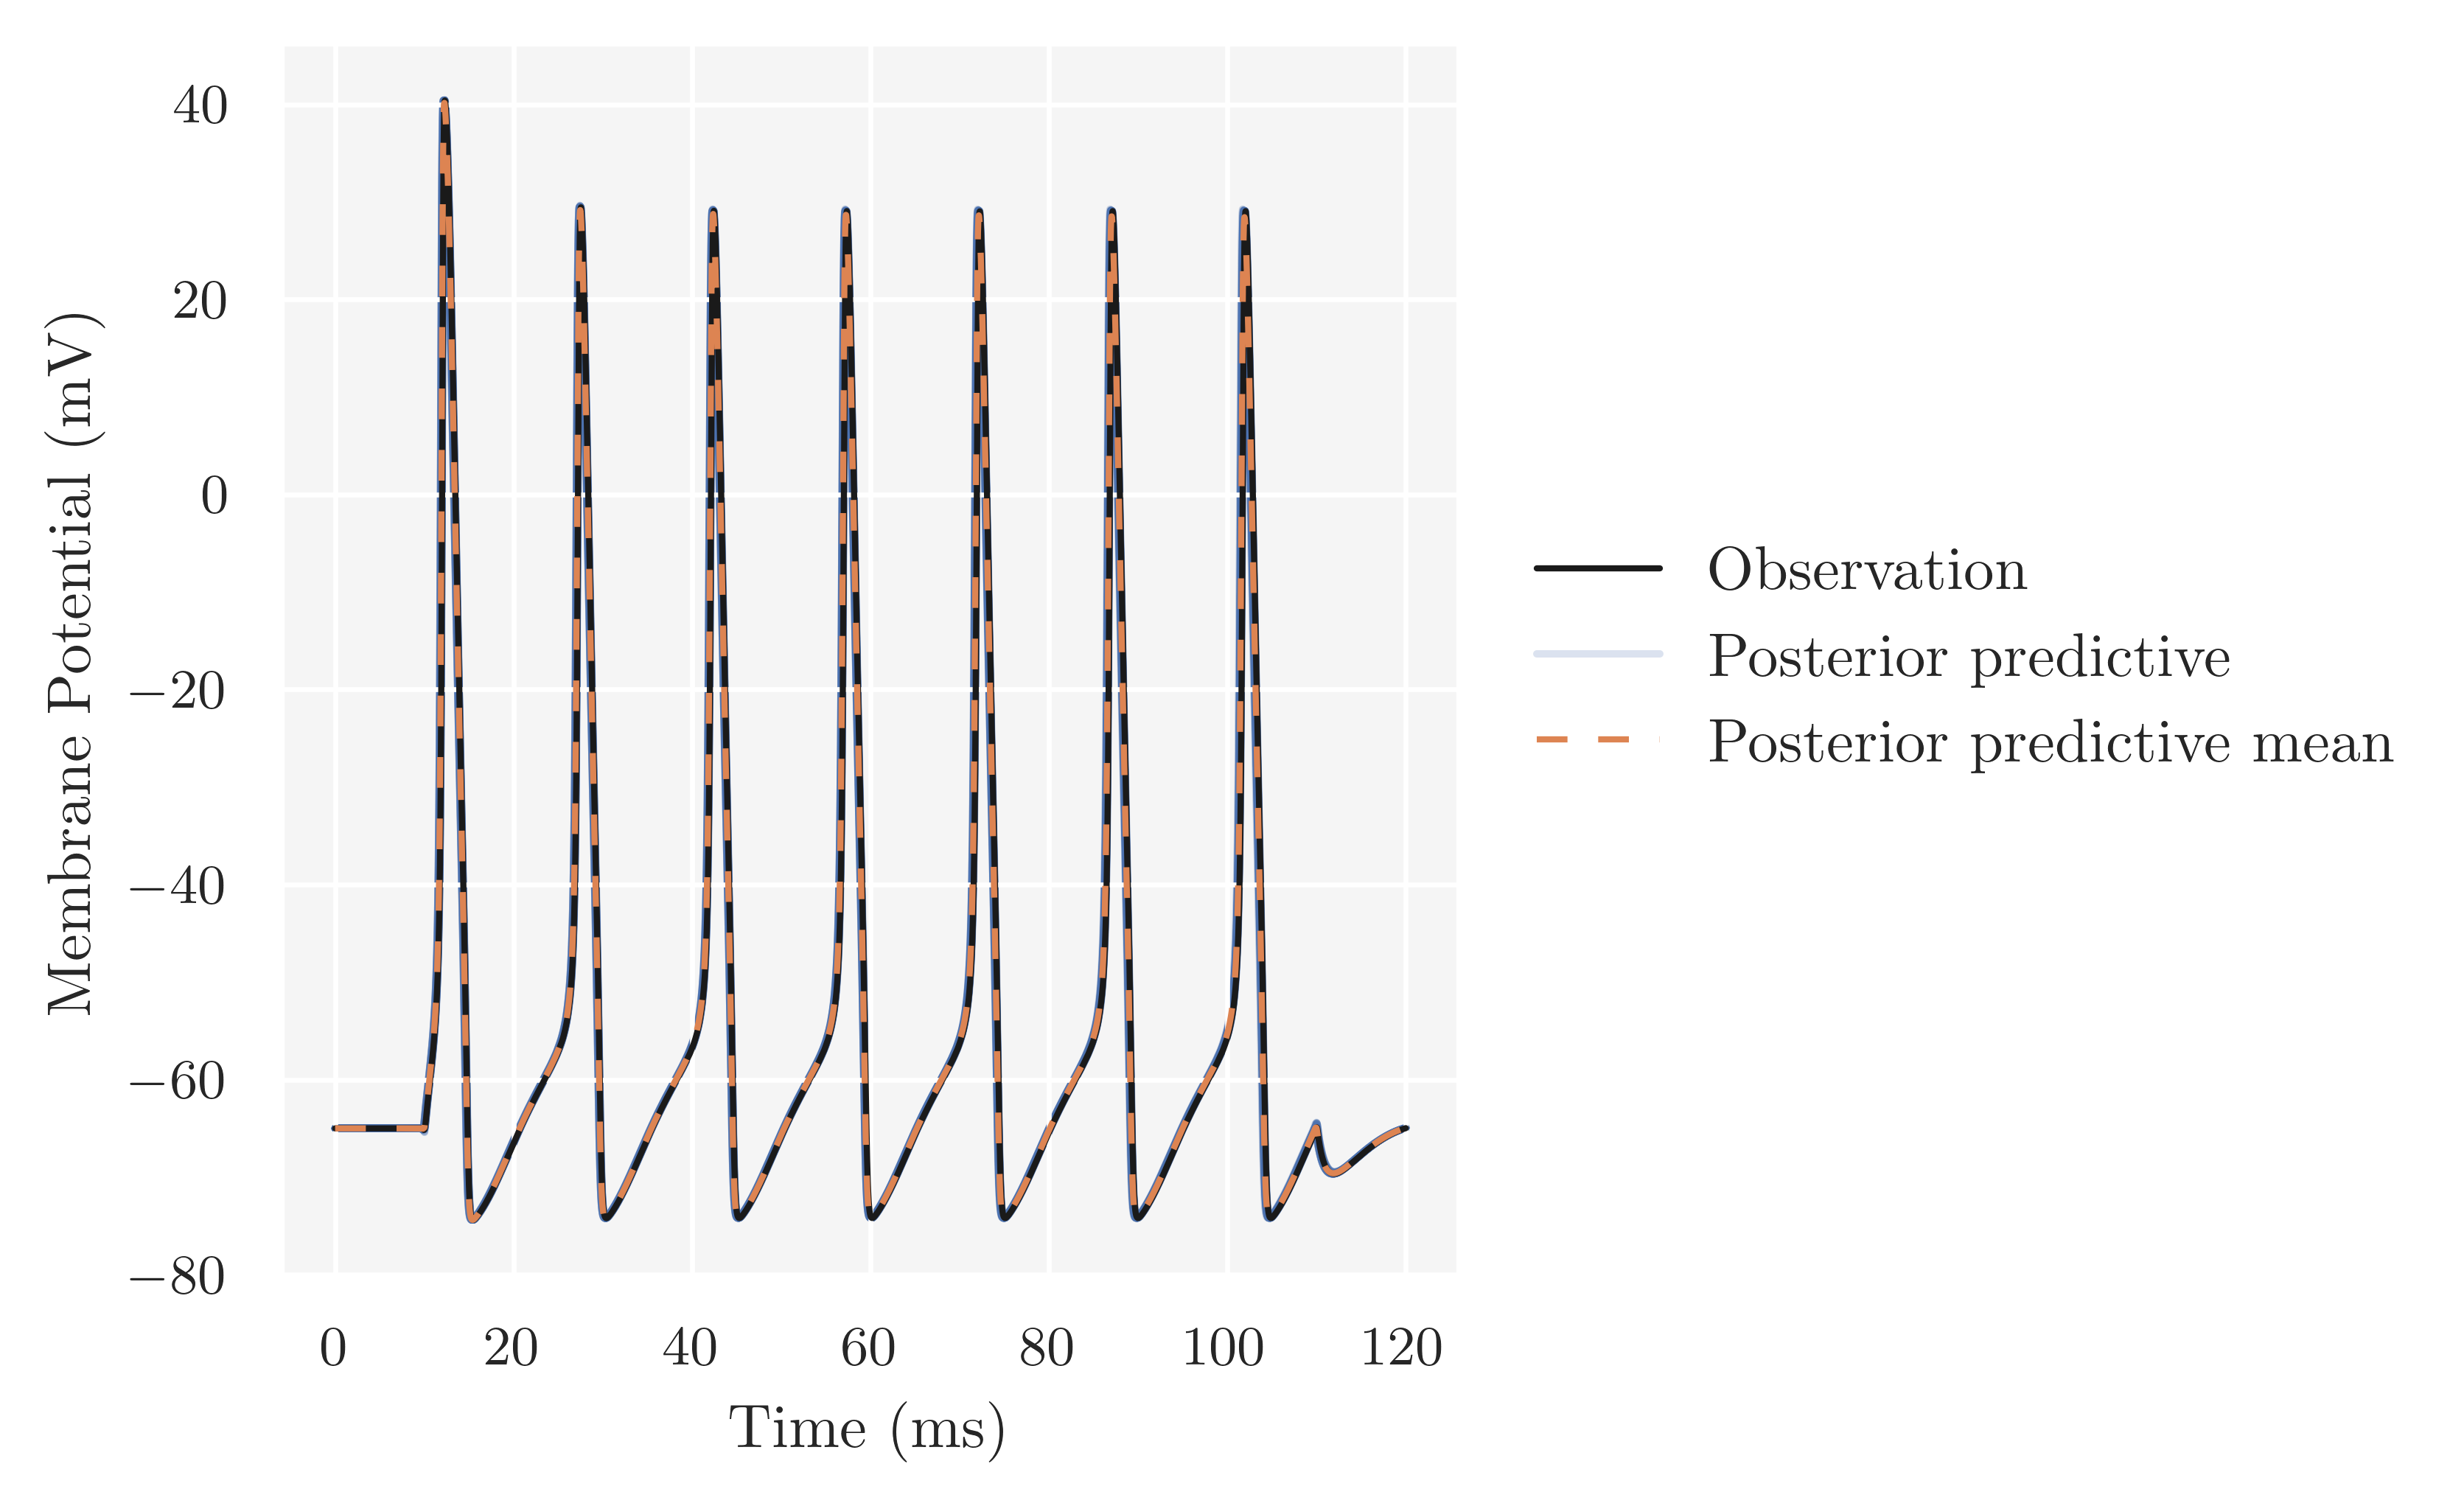

In [16]:
filename = f'hh_rej_normal_best_posterior_reg.jnl'
journal = pylfi.Journal.load(path + filename)

size = 50
thetas_pred = journal.thetas_pred(size)

fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=300)
hh_posterior_predictive(obs_data, hh, thetas_pred, ax=ax)

fig.savefig(fig_path('hh_postpred_reg_normal.pdf'), 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight'
           )

### Original samples, noninformative prior

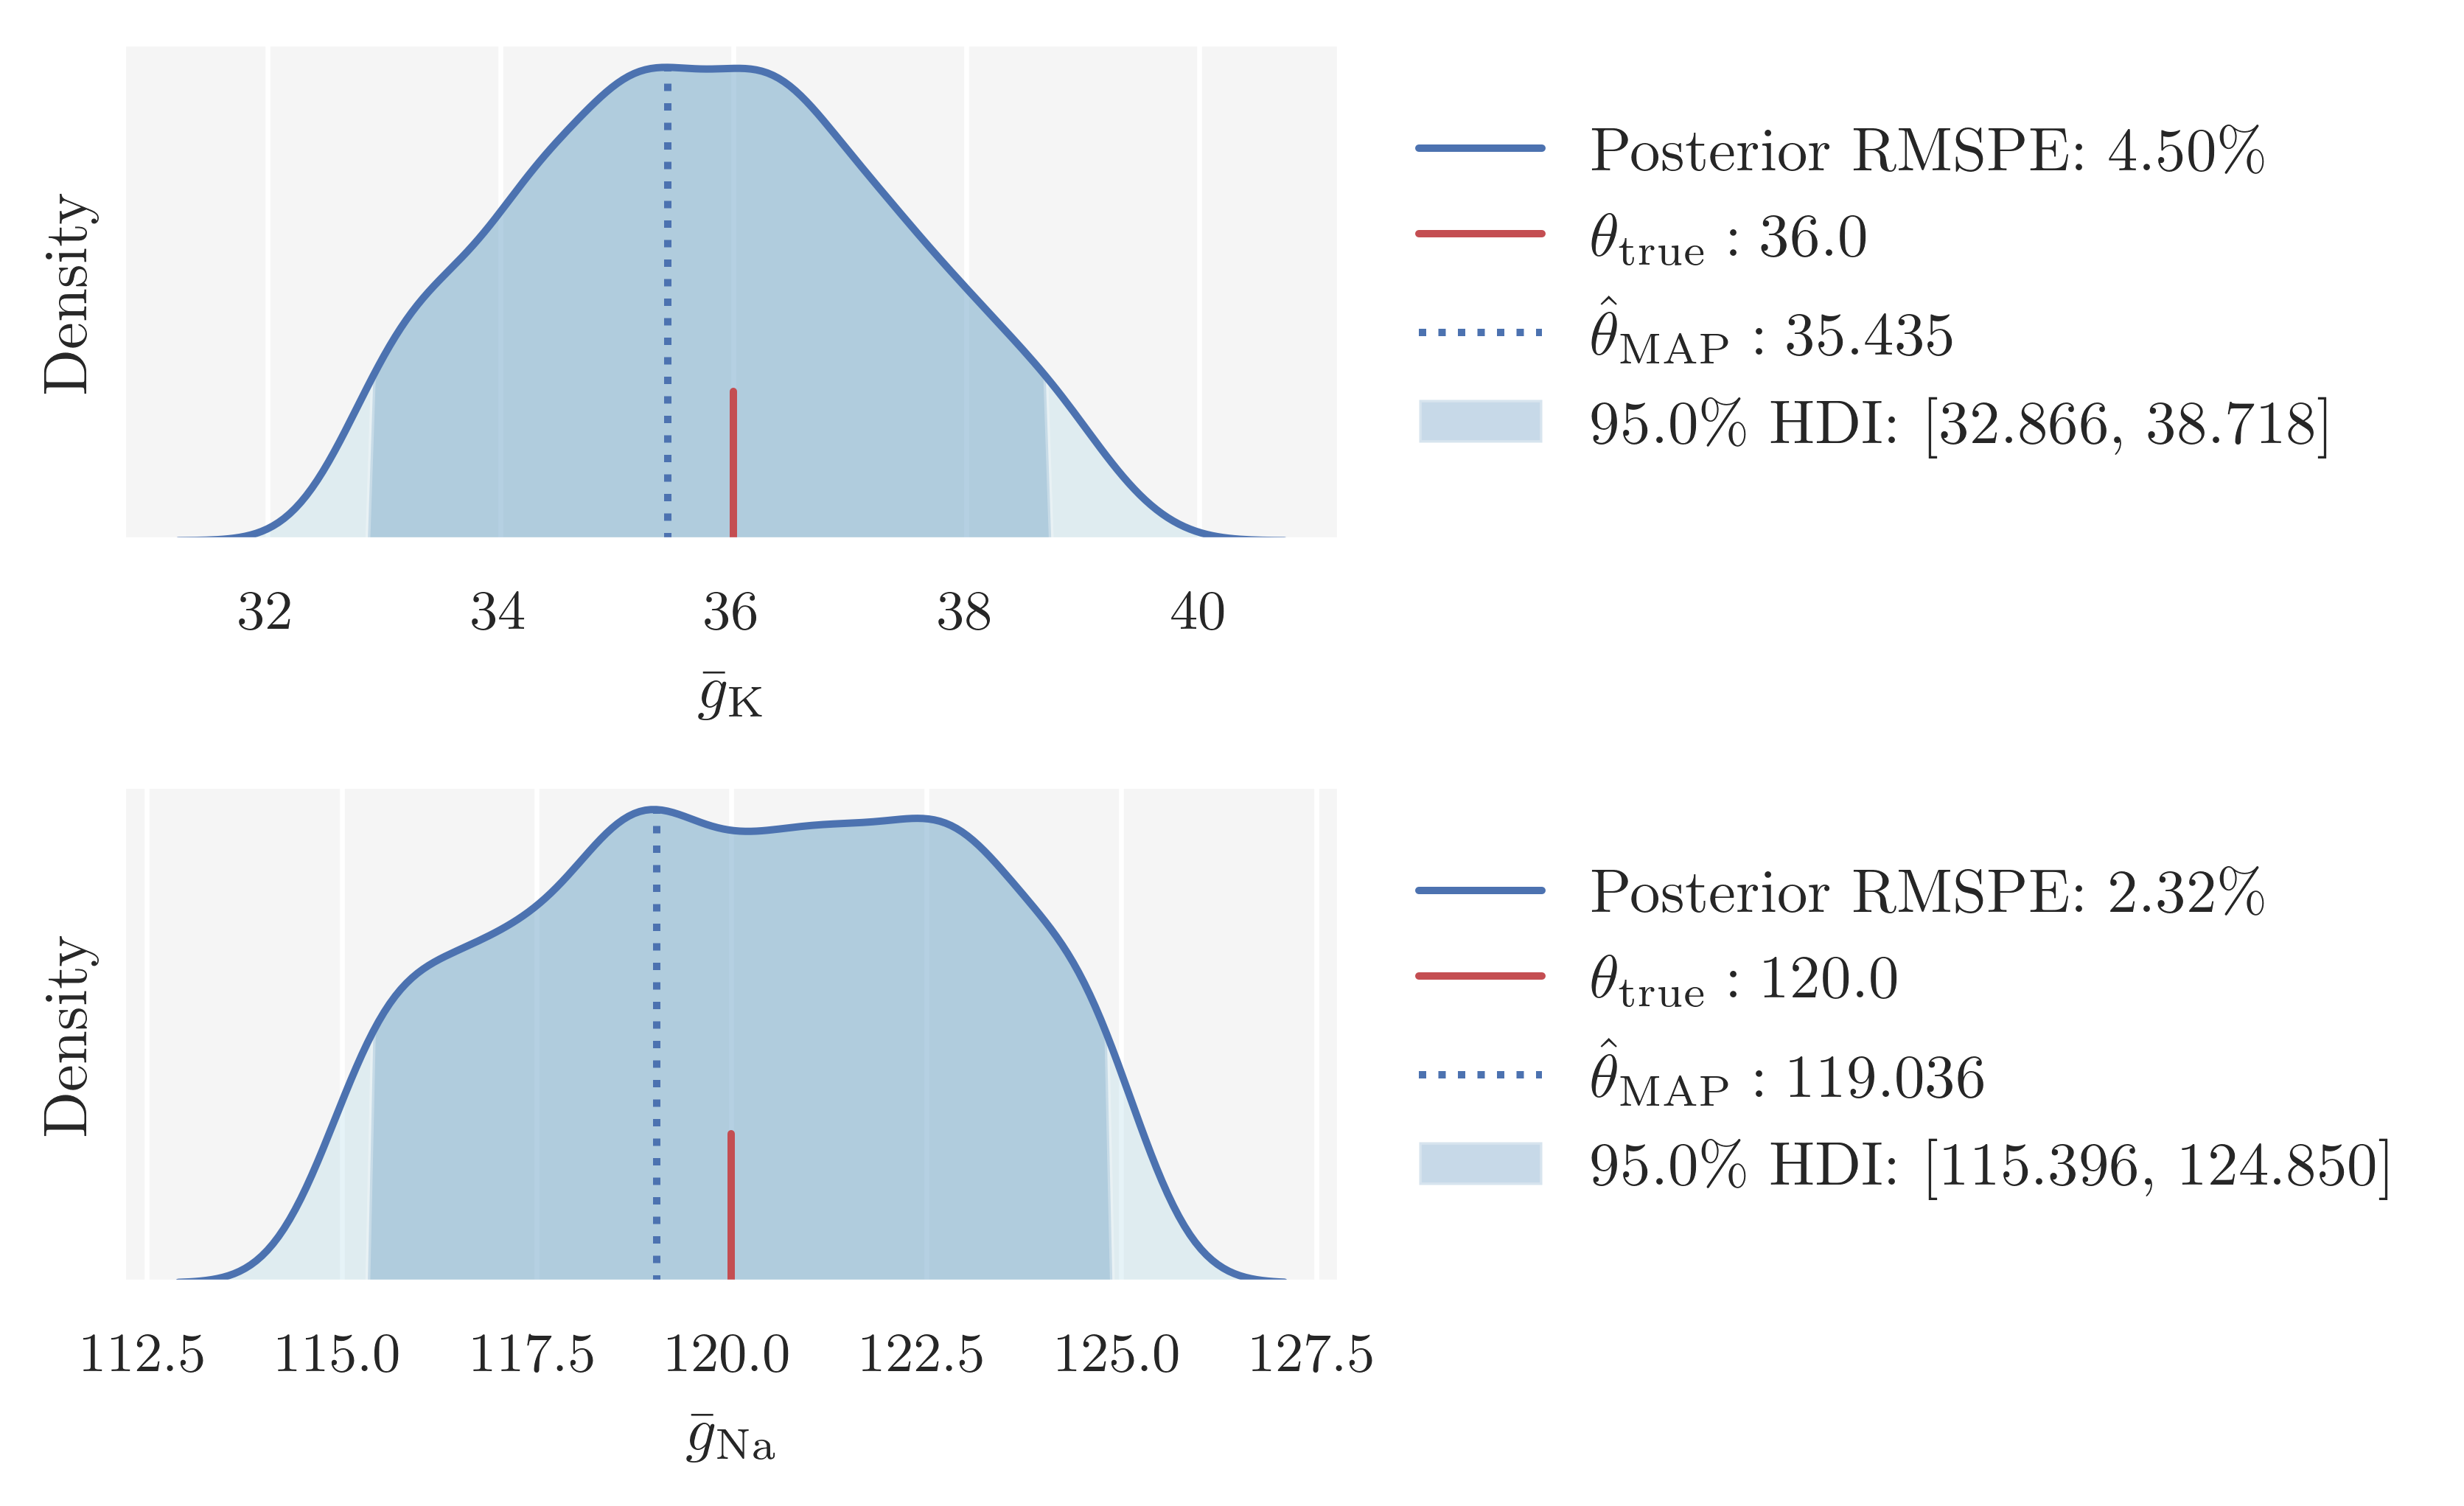

In [17]:
filename = f'hh_rej_uniform_best_posterior_org.jnl'
journal_org = pylfi.Journal.load(path + filename)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=fs, tight_layout=True, dpi=300)
journal_org.plot_posterior('gbarK', point_estimate='map', theta_true=36., ax=axes[0])
journal_org.plot_posterior('gbarNa', point_estimate='map', theta_true=120., ax=axes[1])

fig.savefig(fig_path('hh_posterior_org_uniform.pdf'), 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight'
           )

### Adjusted posterior, noninformative prior

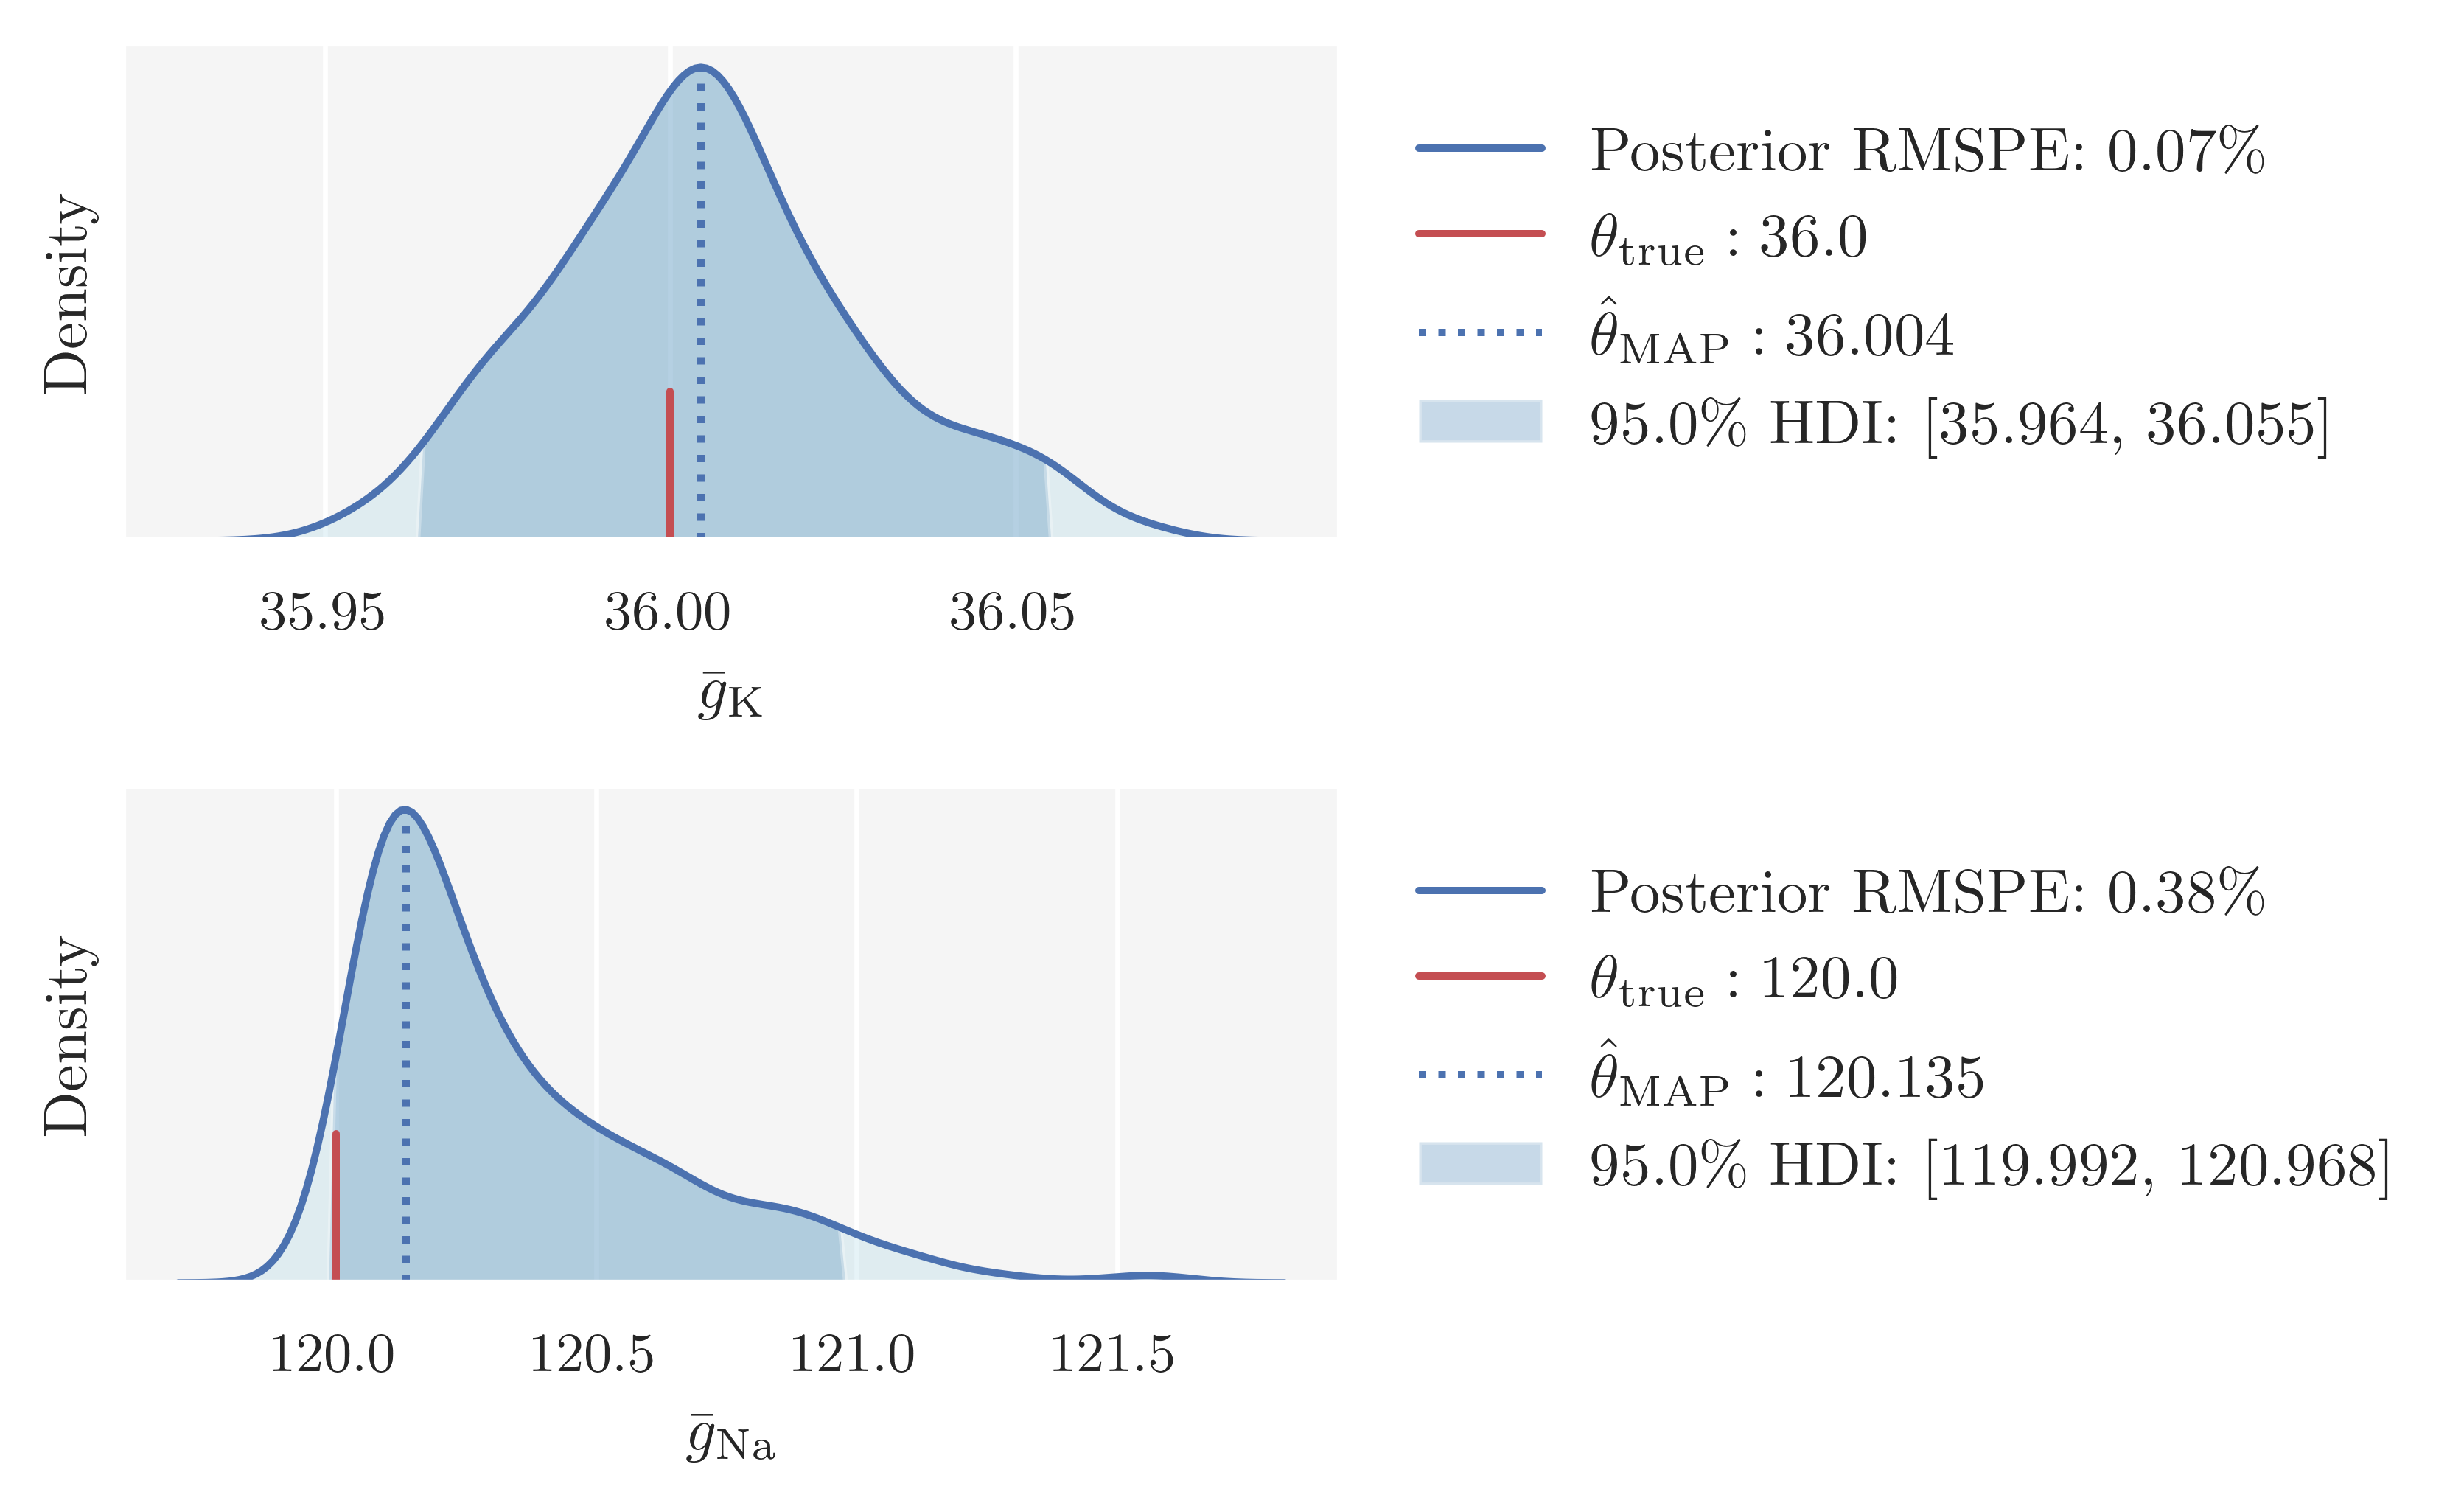

In [18]:
filename = f'hh_rej_uniform_best_posterior_reg.jnl'
journal_reg = pylfi.Journal.load(path + filename)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=fs, tight_layout=True, dpi=300)
journal_reg.plot_posterior('gbarK', point_estimate='map', theta_true=36., ax=axes[0])
journal_reg.plot_posterior('gbarNa', point_estimate='map', theta_true=120., ax=axes[1])

fig.savefig(fig_path('hh_posterior_reg_uniform.pdf'), 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight'
           )

### PPC

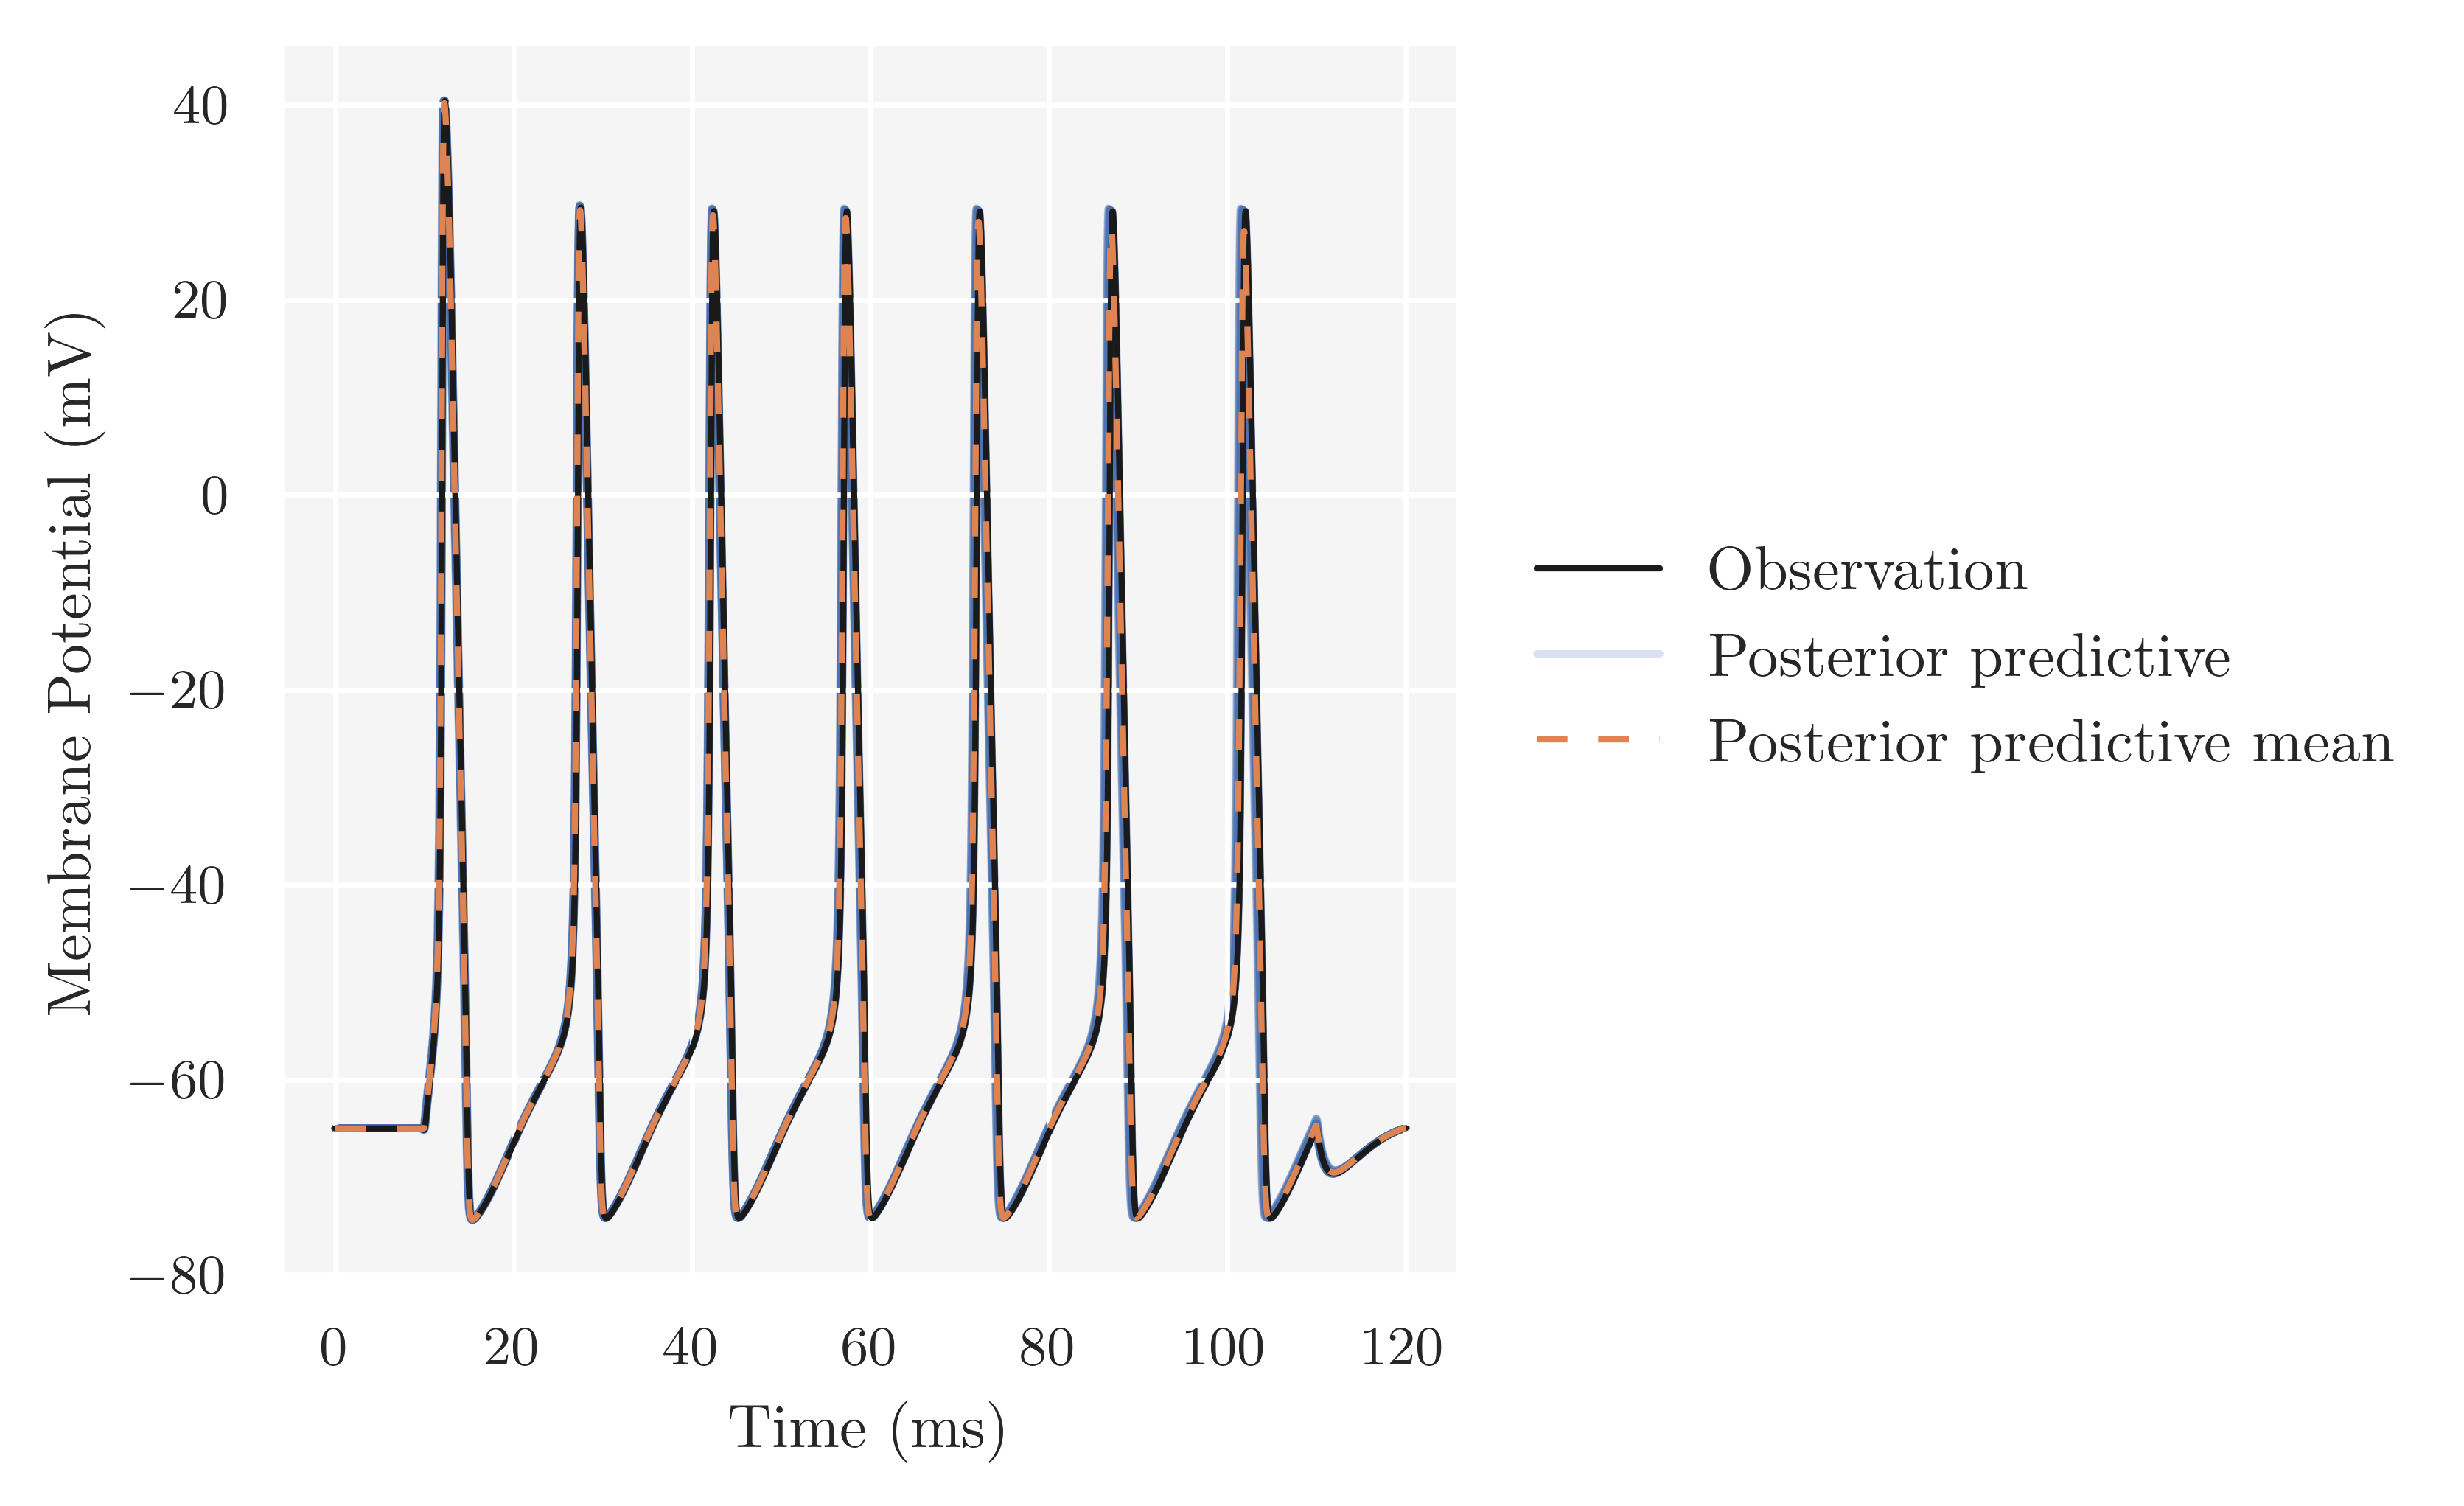

In [19]:
size = 50
thetas_pred = journal_reg.thetas_pred(size)

fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=300)
hh_posterior_predictive(obs_data, hh, thetas_pred, ax=ax)

fig.savefig(fig_path('hh_postpred_reg_uniform.pdf'), 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight'
           )